# Forecasting with Deep Learning

**Deep learning** models have become increasingly popular for time series forecasting, especially when traditional statistical approaches struggle to capture **non-linear relationships or complex temporal patterns**. By leveraging neural network architectures, deep learning methods can automatically learn features and dependencies directly from raw data, offering significant advantages for large datasets, multivariate time series, and problems where classic models fall short.

## Introduction to Recurrent Neural Networks (RNN), LSTM, and GRU

**Recurrent Neural Networks (RNN)** are a family of models specifically designed to work with sequential data, such as time series. Unlike traditional feedforward neural networks, which treat each input independently, RNNs introduce an internal memory that allows them to capture dependencies between elements of a sequence. This enables the model to leverage information from previous steps to improve future predictions.

The fundamental building block of an RNN is the **recurrent cell**, which receives two inputs at each time step: the current data point and the previous hidden state (the "memory" of the network). At every step, the hidden state is updated, storing relevant information about the sequence up to that point. This architecture allows RNNs to “remember” trends and patterns over time.

However, simple RNNs face difficulties when learning long-term dependencies due to issues like the vanishing or exploding gradient problem. To address these limitations, more advanced architectures such as **Long Short-Term Memory (LSTM)** and **Gated Recurrent Unit (GRU)** were developed. These variants are better at capturing complex and long-range patterns in time series data.

<p style="text-align: center">
    <img src='../img/schema-rnn-model.jpg'style="width: 600px">
    <br>
    <font size='2.5'> <i>Basic RNN diagram. Source: James, G., Witten, D., Hastie, T., & Tibshirani, R. (2013). An introduction to statistical learning (1st ed.) [PDF]. Springer.</i></font>
</p>

**Types of Recurrent Layers in skforecast**

With skforecast, you can use three main types of recurrent cells:

+ **Simple RNN:** Suitable for problems with short-term dependencies or when a simple model is sufficient. Less effective for capturing long-range patterns.

+ **LSTM (Long Short-Term Memory):** Adds gating mechanisms that allow the network to learn and retain information over longer periods. LSTMs are a popular choice for many complex forecasting problems.

+ **GRU (Gated Recurrent Unit):** Offers a simpler structure than LSTM, using fewer parameters while achieving comparable performance in many scenarios. Useful when computational efficiency is important.

<div class="admonition note" name="html-admonition" style="background: rgba(0,184,212,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00b8d4; border-color: #00b8d4; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00b8d4;"></i>
    <b style="color: #00b8d4;">&#9998 Note</b>
</p>

Guidelines for choosing a recurrent layer:

<ul>
    <li>
    Use <b>LSTM</b> if your time series contains long-term patterns or complex dependencies.
    </li>
    <li>
    Try <b>GRU</b> as a lighter alternative to LSTM.
    </li>
    <li>
    Use <b>Simple RNN</b> only for straightforward tasks or as a baseline.
    </li>
</ul>

</div>

## LSTM Architecture and Gates

**Long Short-Term Memory (LSTM)** networks are a widely used type of recurrent neural network designed to effectively capture **long-range dependencies in sequential data**. Unlike simple RNNs, LSTMs use a more sophisticated architecture based on a system of memory cells and gates that control the flow of information over time.

The core component of an LSTM is the **memory cell**, which maintains information across time steps. Three gates regulate how information is added, retained, or discarded at each step:

+ **Forget Gate:** Decides which information from the previous cell state should be removed. It uses the current input and previous hidden state, applying a sigmoid activation to produce a value between 0 and 1 (where 0 means “completely forget” and 1 means “completely keep”).

+ **Input Gate:** Controls how much new information is added to the cell state, again using the current input and previous hidden state with a sigmoid activation.

+ **Output Gate:** Determines how much of the cell state is exposed as output and passed to the next hidden state.

This gating mechanism enables LSTMs to selectively remember or forget information, making them highly effective for modeling sequences with long-term patterns.

<p style="text-align: center">
    <img src='https://databasecamp.de/wp-content/uploads/lstm-architecture-1024x709.png'style="width: 400px">
    <br>
    <font size='2.5'> <i>Diagram of the inputs and outputs of an LSTM. Source: codificandobits https://databasecamp.de/wp-content/uploads/lstm-architecture-1024x709.png.</i></font>
</p>

**Gated Recurrent Unit (GRU)** cells are a simplified alternative to LSTMs, using only two gates (reset and update) but often achieving similar performance. GRUs require fewer parameters and can be computationally more efficient, which may be an advantage for some tasks or larger datasets.

<div class="admonition note" name="html-admonition" style="background: rgba(0,191,191,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00bfa5; border-color: #00bfa5; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00bfa5;"></i>
    <b style="color: #00bfa5;">&#128161 Tip</b>
</p>

To learn more about forecasting with deep learning  models visit our examples:

<ul>
    <li>
    <a href="https://www.cienciadedatos.net/documentos/py54-forecasting-with-deep-learning.html">Deep Learning for time series forecasting: Recurrent Neural Networks (RNN) and Long Short-Term Memory (LSTM)</a>.
    </li>
</ul>

</div>

## Libraries and data

<div class="admonition note" name="html-admonition" style="background: rgba(255,145,0,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #ff9100; border-color: #ff9100; padding-left: 10px; padding-right: 10px">

<p class="title">
    <i style="font-size: 18px; color:#ff9100; border-color: #ff1744;"></i>
    <b style="color: #ff9100;"> <span style="color: #ff9100;">&#9888;</span> Warning</b>
</p>

skforecast supports multiple Keras backends: <b>TensorFlow</b>, <b>JAX</b>, and <b>PyTorch (torch)</b>.
You can select the backend using the <code>KERAS_BACKEND</code> environment variable, or by editing your local configuration file at <code>~/.keras/keras.json</code>.

```python
import os
os.environ["KERAS_BACKEND"] = "tensorflow"  # Options: "tensorflow", "jax", or "torch"
import keras
```

The backend must be set before importing Keras in your Python session. Once Keras is imported, the backend cannot be changed without restarting your Python process.

Alternatively, you can set the backend in your configuration file at <code>~/.keras/keras.json</code>:

```json
{
    "backend": "tensorflow"  # Options: "tensorflow", "jax", or "torch"
}
```

</div>

In [1]:
# Libraries
# ==============================================================================
import os
os.environ["KERAS_BACKEND"] = "tensorflow"  # 'tensorflow', 'jax´ or 'torch'
import keras

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from feature_engine.datetime import DatetimeFeatures
from feature_engine.creation import CyclicalFeatures

import skforecast
from skforecast.plot import set_dark_theme
from skforecast.datasets import fetch_dataset
from skforecast.deep_learning import create_and_compile_model
from skforecast.deep_learning import ForecasterRnn
from skforecast.model_selection import TimeSeriesFold
from skforecast.model_selection import backtesting_forecaster_multiseries
from skforecast.plot import plot_prediction_intervals

from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

print(f"skforecast version: {skforecast.__version__}")
print(f"keras version: {keras.__version__}")
print(f"Using backend: {keras.backend.backend()}")
if keras.backend.backend() == "tensorflow":
    import tensorflow as tf
    print(f"tensorflow version: {tf.__version__}")
elif keras.backend.backend() == "torch":
    import torch
    print(f"torch version: {torch.__version__}")
else:
    print("Backend not recognized. Please use 'tensorflow' or 'torch'.")

skforecast version: 0.19.0
keras version: 3.10.0
Using backend: tensorflow
tensorflow version: 2.19.0


In [2]:
# Data download
# ==============================================================================
data = fetch_dataset(name="air_quality_valencia_no_missing")
data.head()

╭──────────────────────── air_quality_valencia_no_missing ─────────────────────────╮
│ Description:                                                                     │
│ Hourly measures of several air chemical pollutant at Valencia city (Avd.         │
│ Francia) from 2019-01-01 to 20213-12-31. Including the following variables:      │
│ pm2.5 (µg/m³), CO (mg/m³), NO (µg/m³), NO2 (µg/m³), PM10 (µg/m³), NOx (µg/m³),   │
│ O3 (µg/m³), Veloc. (m/s), Direc. (degrees), SO2 (µg/m³). Missing values have     │
│ been imputed using linear interpolation.                                         │
│                                                                                  │
│ Source:                                                                          │
│ Red de Vigilancia y Control de la Contaminación Atmosférica, 46250047-València - │
│ Av. França, https://mediambient.gva.es/es/web/calidad-ambiental/datos-           │
│ historicos.                                                                      │
│                                                                                  │
│ URL:                                                                             │
│ https://raw.githubusercontent.com/skforecast/skforecast-                         │
│ datasets/main/data/air_quality_valencia_no_missing.csv                           │
│                                                                                  │
│ Shape: 43824 rows x 10 columns                                                   │
╰──────────────────────────────────────────────────────────────────────────────────╯

,so2,co,no,no2,pm10,nox,o3,veloc.,direc.,pm2.5
datetime,,,,,,,,,,
2019-01-01 00:00:00,8.0,0.2,3.0,36.0,22.0,40.0,16.0,0.5,262.0,19.0
2019-01-01 01:00:00,8.0,0.1,2.0,40.0,32.0,44.0,6.0,0.6,248.0,26.0
2019-01-01 02:00:00,8.0,0.1,11.0,42.0,36.0,58.0,3.0,0.3,224.0,31.0
2019-01-01 03:00:00,10.0,0.1,15.0,41.0,35.0,63.0,3.0,0.2,220.0,30.0
2019-01-01 04:00:00,11.0,0.1,16.0,39.0,36.0,63.0,3.0,0.4,221.0,30.0


In [3]:
# Checking the frequency of the time series
# ==============================================================================
print(f"Index     : {data.index.dtype}")
print(f"Frequency : {data.index.freqstr}")

Index     : datetime64[ns]
Frequency : h


In [4]:
# Split train-validation-test
# ==============================================================================
data = data.loc["2019-01-01 00:00:00":"2021-12-31 23:59:59", :].copy()

end_train = "2021-03-31 23:59:00"
end_validation = "2021-09-30 23:59:00"
data_train = data.loc[:end_train, :].copy()
data_val = data.loc[end_train:end_validation, :].copy()
data_test = data.loc[end_validation:, :].copy()

print(
    f"Dates train      : {data_train.index.min()} --- " 
    f"{data_train.index.max()}  (n={len(data_train)})"
)
print(
    f"Dates validation : {data_val.index.min()} --- " 
    f"{data_val.index.max()}  (n={len(data_val)})"
)
print(
    f"Dates test       : {data_test.index.min()} --- " 
    f"{data_test.index.max()}  (n={len(data_test)})"
)

Dates train      : 2019-01-01 00:00:00 --- 2021-03-31 23:00:00  (n=19704)
Dates validation : 2021-04-01 00:00:00 --- 2021-09-30 23:00:00  (n=4392)
Dates test       : 2021-10-01 00:00:00 --- 2021-12-31 23:00:00  (n=2208)


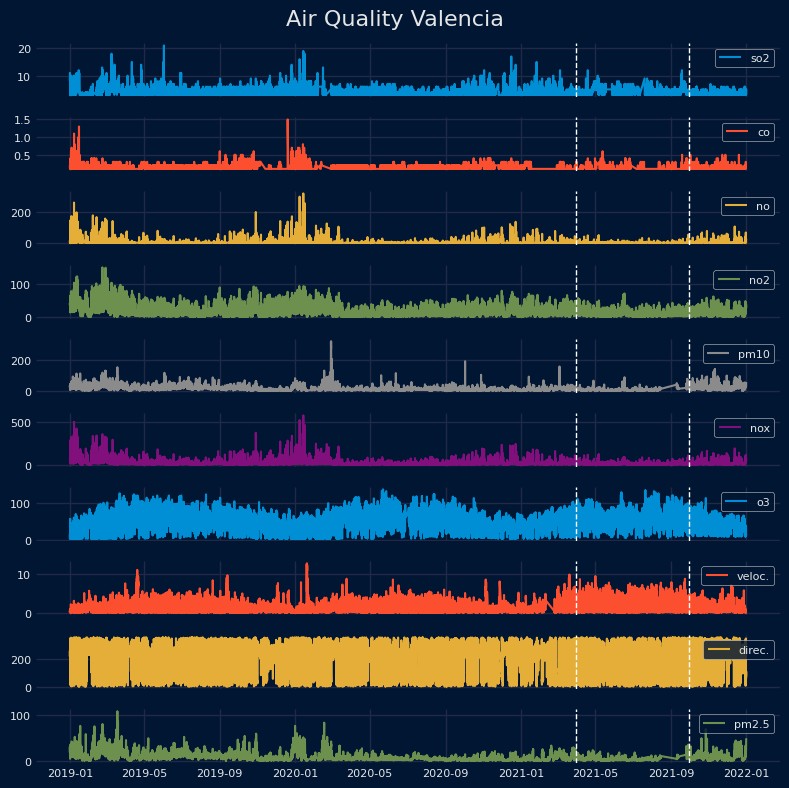

In [5]:
# Plot series
# ==============================================================================
set_dark_theme()
colors = plt.rcParams['axes.prop_cycle'].by_key()['color'] * 2
fig, axes = plt.subplots(len(data.columns), 1, figsize=(8, 8), sharex=True)

for i, col in enumerate(data.columns):
    axes[i].plot(data[col], label=col, color=colors[i])
    axes[i].legend(loc='upper right', fontsize=8)
    axes[i].tick_params(axis='both', labelsize=8)
    axes[i].axvline(pd.to_datetime(end_train), color='white', linestyle='--', linewidth=1)  # End train
    axes[i].axvline(pd.to_datetime(end_validation), color='white', linestyle='--', linewidth=1)  # End validation

fig.suptitle("Air Quality Valencia", fontsize=16)
plt.tight_layout()

## Building RNN-based models easily with create_and_compile_model

skforecast provides the utility function `create_and_compile_model` to simplify the creation of recurrent neural network architectures (RNN, LSTM, or GRU) for time series forecasting. This function is designed to make it easy for both beginners and advanced users to build and compile **Keras** models with just a few lines of code.

**Basic usage**

For most forecasting scenarios, you can simply specify the time series data, the number of lagged observations, the number of steps to predict, and the type of recurrent layer you wish to use ([LSTM](https://keras.io/api/layers/recurrent_layers/lstm/), [GRU](https://keras.io/api/layers/recurrent_layers/gru/), or [SimpleRNN](https://keras.io/api/layers/recurrent_layers/simple_rnn/)). By default, the function sets reasonable parameters for each layer, but all architectural details can be adjusted to fit specific requirements.

In [6]:
# Basic usage of `create_and_compile_model`
# ==============================================================================
model = create_and_compile_model(
            series          = data,    # All 10 series are used as predictors
            levels          = ["o3"],  # Target series to predict
            lags            = 32,      # Number of lags to use as predictors
            steps           = 24,      # Number of steps to predict
            recurrent_layer = "LSTM",  # Type of recurrent layer ('LSTM', 'GRU', or 'RNN')
            recurrent_units = 100,     # Number of units in the recurrent layer
            dense_units     = 64       # Number of units in the dense layer
        )

model.summary()

keras version: 3.10.0
Using backend: tensorflow
tensorflow version: 2.19.0



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ series_input (InputLayer)       │ (None, 32, 10)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100)            │        44,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         6,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_dense_td_layer (Dense)   │ (None, 24)             │         1,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 24, 1)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,424 (204.78 KB)

 Trainable params: 52,424 (204.78 KB)

 Non-trainable params: 0 (0.00 B)

**Advanced customization**

All arguments controlling layer types, units, activations, and other options can be customized. You may also pass your own Keras model if you need full flexibility beyond what the helper function provides.

The arguments `recurrent_layers_kwargs` and `dense_layers_kwargs` allow you to specify the parameters for the recurrent and dense layers, respectively. 

+ When using a dictionary, the kwargs are replayed for each layer of the same type. For example, if you specify `recurrent_layers_kwargs = {'activation': 'tanh'}`, all recurrent layers will use the `tanh` activation function. 

+ You can also pass a list of dictionaries to specify different parameters for each layer. For instance, `recurrent_layers_kwargs = [{'activation': 'tanh'}, {'activation': 'relu'}]` will specify that the first recurrent layer uses the `tanh` activation function and the second uses `relu`.

In [7]:
# Advance usage of `create_and_compile_model`
# ==============================================================================
model = create_and_compile_model(
    series                    = data,
    levels                    = ["o3"], 
    lags                      = 32,
    steps                     = 24,
    exog                      = None,  # No exogenous variables
    recurrent_layer           = "LSTM",    
    recurrent_units           = [128, 64],  
    recurrent_layers_kwargs   = [{'activation': 'tanh'}, {'activation': 'relu'}],
    dense_units               = [128, 64],
    dense_layers_kwargs       = {'activation': 'relu'},
    output_dense_layer_kwargs = {'activation': 'linear'},
    compile_kwargs            = {'optimizer': Adam(learning_rate=0.001), 'loss': MeanSquaredError()},
    model_name                = None
)

model.summary()

keras version: 3.10.0
Using backend: tensorflow
tensorflow version: 2.19.0



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ series_input (InputLayer)       │ (None, 32, 10)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32, 128)        │        71,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_dense_td_layer (Dense)   │ (None, 24)             │         1,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 24, 1)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,712 (541.84 KB)

 Trainable params: 138,712 (541.84 KB)

 Non-trainable params: 0 (0.00 B)

To gain a deeper understanding of this function, refer to a later section of this guide: [Understanding `create_and_compile_model` in depth](../user_guides/forecasting-with-deep-learning-rnn-lstm.html#understanding-create-and-compile-model-in-depth).

If you need to define a **completely custom architecture**, you can create your own Keras model and use it directly in skforecast workflows.

In [8]:
# Plotting the model architecture (require `pydot` and `graphviz`)
# ==============================================================================
# from keras.utils import plot_model
# plot_model(model, show_shapes=True, show_layer_names=True, to_file='model-architecture.png')

<p style="text-align: center">
    <img src='../img/model-architecture.png'style="width: 300px">
</p>

## Types of problems in time series forecasting

Deep learning models for time series can handle a **wide variety of forecasting scenarios**, depending on how you structure your input data and define your prediction targets. These models are flexible enough to:

+ Predict a single value or multiple future values (single-step vs multi-step forecasting).

+ Work with a single time series or multiple series (both as predictors and as targets).

+ Incorporate exogenous variables (external features or known future information) alongside your main time series data.

By adjusting your **data inputs** (number of series, steps ahead to predict, and exogenous variables) deep learning architectures can be adapted to solve almost any classical or advanced forecasting problem.

### 1. Single-Series, Single-Step Forecasting (1:1)

In this scenario, the goal is to predict the next value in a single time series, using only its own past observations as predictors. This is known as a univariate autoregressive forecasting problem.

For example: Given a sequence of values ${y_{t-3}, y_{t-2}, y_{t-1}}$, predict $y_{t+1}$.

This setup is common for classic time series tasks and serves as a good starting point for experimenting with deep learning models.

In [9]:
# Create model
# ==============================================================================
lags = 24

model = create_and_compile_model(
    series                  = data[["o3"]],  # Only the 'o3' series is used as predictor
    levels                  = ["o3"],        # Target series to predict
    lags                    = lags,          # Number of lags to use as predictors
    steps                   = 1,             # Single-step forecasting
    recurrent_layer         = "GRU",
    recurrent_units         = 64,
    recurrent_layers_kwargs = {"activation": "tanh"},
    dense_units             = 32,
    compile_kwargs          = {'optimizer': Adam(), 'loss': MeanSquaredError()},
    model_name              = "Single-Series-Single-Step" 
)

model.summary()

keras version: 3.10.0
Using backend: tensorflow
tensorflow version: 2.19.0



Model: "Single-Series-Single-Step"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ series_input (InputLayer)       │ (None, 24, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 64)             │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_dense_td_layer (Dense)   │ (None, 1)              │            33 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 1, 1)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,977 (58.50 KB)

 Trainable params: 14,977 (58.50 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Forecaster Definition
# ==============================================================================
forecaster = ForecasterRnn(
    estimator=model,
    levels=["o3"],
    lags=lags,  # Must be same lags as used in create_and_compile_model
    transformer_series=MinMaxScaler(),
    fit_kwargs={
        "epochs": 25,       # Number of epochs to train the model.
        "batch_size": 512,  # Batch size to train the model.
        "callbacks": [
            EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
        ],  # Callback to stop training when it is no longer learning.
        "series_val": data_val,  # Validation data for model training.
    },
)

# Fit forecaster
# ==============================================================================
forecaster.fit(data_train[['o3']])
forecaster

Epoch 1/25


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 16 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0885 - val_loss: 0.0161
Epoch 2/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0136 - val_loss: 0.0103
Epoch 3/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0103 - val_loss: 0.0088
Epoch 4/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0087 - val_loss: 0.0073
Epoch 5/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0076 - val_loss: 0.0066
Epoch 6/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0066 - val_loss: 0.0060
Epoch 7/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0062 - val_loss: 0.0058
Epoch 8/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0058 - val_loss: 0.0056
Epoch 9/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0056 - val_loss: 0.0056
Epoch 10/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0055 - val_loss: 0.0056
Epoch 11/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0055 - val_loss: 0.0056
Epoch 12/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0055 - val_loss: 0.005

============= 
ForecasterRnn 
============= 
Estimator: <Functional name=Single-Series-Single-Step, built=True> 
Layers names: ['series_input', 'gru_1', 'dense_1', 'output_dense_td_layer', 'reshape'] 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Window size: 24 
Maximum steps to predict: [1] 
Series names: o3 
Target series (levels): ['o3'] 
Exogenous included: False 
Exogenous names: None 
Transformer for series: MinMaxScaler() 
Transformer for exog: MinMaxScaler() 
Training range: [Timestamp('2019-01-01 00:00:00'), Timestamp('2021-03-31 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: <Hour> 
Estimator parameters: {'name': 'Single-Series-Single-Step', 'trainable': True, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': (None, 24, 1), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'series_input'}, 'registered_name': None, 'name': 'series_input', 'inbound_nodes': []}, {'module': 'keras.layers', 'class_name': 'GRU', 'config': {'name': 'gru_1', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'return_sequences': False, 'return_state': False, 'go_backwards': False, 'stateful': False, 'unroll': False, 'zero_output_for_mask': False, 'units': 64, 'activation': 'tanh', 'recurrent_activation': 'sigmoid', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'recurrent_initializer': {'module': 'keras.initializers', 'class_name': 'Orthogonal', 'config': {'seed': None, 'gain': 1.0}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'recurrent_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'recurrent_constraint': None, 'bias_constraint': None, 'dropout': 0.0, 'recurrent_dropout': 0.0, 'reset_after': True, 'seed': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 24, 1]}, 'name': 'gru_1', 'inbound_nodes': [{'args': ({'class_name': '__keras_tensor__', 'config': {'shape': (None, 24, 1), 'dtype': 'float32', 'keras_history': ['series_input', 0, 0]}},), 'kwargs': {'training': False, 'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_1', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'units': 32, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64]}, 'name': 'dense_1', 'inbound_nodes': [{'args': ({'class_name': '__keras_tensor__', 'config': {'shape': (None, 64), 'dtype': 'float32', 'keras_history': ['gru_1', 0, 0]}},), 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'output_dense_td_layer', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'units': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_sh

<div class="admonition note" name="html-admonition" style="background: rgba(0,184,212,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00b8d4; border-color: #00b8d4; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00b8d4;"></i>
    <b style="color: #00b8d4;">&#9998 Note</b>
</p>

The **skforecast** library is fully compatible with GPUs. See the **Running on GPU** section below in this document for more information.

</div>

In *deep learning* models, it’s important to **control overfitting**, when a model performs well on training data but poorly on new, unseen data. One common approach is to use a Keras callback, such as `EarlyStopping`, which halts training if the validation loss stops improving.

Another useful practice is to **plot the training and validation loss** after each epoch. This helps you visualize how the model is learning and spot signs of overfitting.

<p style="text-align: center">
    <img src='../img/overfitting3.jpg'style="width: 500px">
    <br>
    <font size='2.5'> <i>Graphical explanation of overfitting. Source: https://datahacker.rs/018-pytorch-popular-techniques-to-prevent-the-overfitting-in-a-neural-networks/.</i></font>
</p>

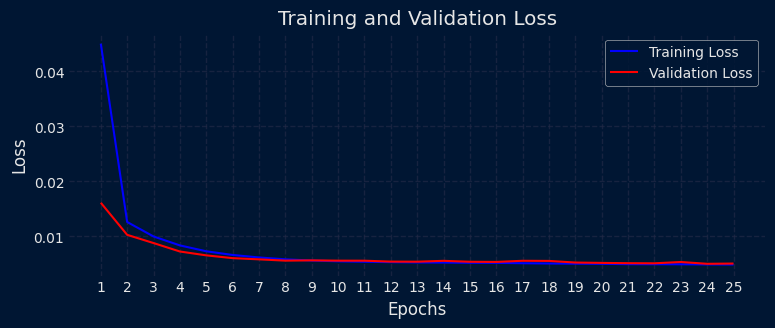

In [11]:
# Track training and overfitting
# ==============================================================================
fig, ax = plt.subplots(figsize=(8, 3))
_ = forecaster.plot_history(ax=ax)

In the plot above, the training loss (blue) decreases rapidly during the first two epochs, indicating the model is quickly capturing the main patterns in the data. The validation loss (red) starts low and remains stable throughout the training process, closely following the training loss. This suggests:

+ **The model is not overfitting**, as the validation loss stays close to the training loss for all epochs.

+ **Both losses decrease and stabilize together**, indicating good generalization and effective learning.

+ **No divergence is observed**, which would appear as the validation loss increasing while training loss keeps decreasing.

In [12]:
# Predictions
# ==============================================================================
predictions = forecaster.predict()
predictions

,level,pred
2021-04-01,o3,45.541958


In time series forecasting, the process of *backtesting* consists of evaluating the performance of a predictive model by applying it retrospectively to historical data. Therefore, it is a special type of cross-validation applied to the previous period(s). To learn more about backtesting, visit the [backtesting user guide](../user_guides/backtesting.html).

In [13]:
# Backtesting with test data
# ==============================================================================
cv = TimeSeriesFold(
         steps              = forecaster.max_step,
         initial_train_size = len(data.loc[:end_validation, :]),  # Training + Validation Data
         refit              = False
     )

# The validation partition is now used as part of the initial fit
# Epocs is set to the value idenfied in the previous training with early stopping
forecaster.set_fit_kwargs({"epochs": 15,"batch_size": 512})

metrics, predictions = backtesting_forecaster_multiseries(
    forecaster  = forecaster,
    series      = data[['o3']],
    cv          = cv,
    levels      = forecaster.levels,
    metric      = "mean_absolute_error",
    verbose     = False  # Set to True for detailed output
)

Epoch 1/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0049 - val_loss: 0.0056
Epoch 2/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0050 - val_loss: 0.0050
Epoch 3/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0048 - val_loss: 0.0050
Epoch 4/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0048 - val_loss: 0.0061
Epoch 5/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0054 - val_loss: 0.0053
Epoch 6/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0050 - val_loss: 0.0051
Epoch 7/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0048 - val_loss: 0.0049
Epoch 8/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0048 - val_loss: 0.0049
Epoch 9/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0047 - val_loss: 0.0048
Epoch 10/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0047 - val_loss: 0.0048
Epoch 11/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0046 - val_loss: 0.0049
Epoch 12/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0047 - val_l

  0%|          | 0/2208 [00:00<?, ?it/s]

In [14]:
# Backtesting metrics
# ==============================================================================
metrics

,levels,mean_absolute_error
0,o3,6.212774


In [15]:
# Backtesting predictions
# ==============================================================================
predictions.head(4)

,level,fold,pred
2021-10-01 00:00:00,o3,0,49.818016
2021-10-01 01:00:00,o3,1,53.446335
2021-10-01 02:00:00,o3,2,56.901424
2021-10-01 03:00:00,o3,3,56.867065


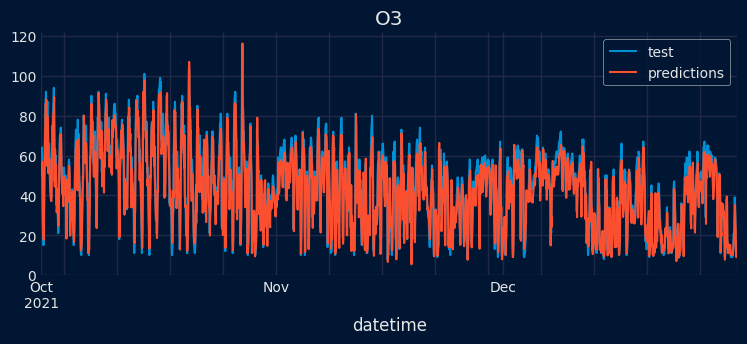

In [16]:
# Plotting predictions vs real values in the test set
# ==============================================================================
fig, ax = plt.subplots(figsize=(8, 3))
data_test["o3"].plot(ax=ax, label="test")
predictions.loc[predictions["level"] == "o3", "pred"].plot(ax=ax, label="predictions")
ax.set_title("O3")
ax.legend();

### 2. Single-Series, Multi-Step Forecasting (1:1, Multiple Steps)

In this scenario, the objective is to predict multiple future values of a single time series using only its own past observations as predictors. This is known as **multi-step univariate forecasting**.

For example: Given a sequence of values ${y_{t-24}, ..., y_{t-1}}$, predict ${y_{t+1}, y_{t+2}, ..., y_{t+n}}$, where $n$ is the prediction horizon (number of steps ahead).

This setup is common when you want to forecast several periods into the future (e.g., the next 24 hours of ozone concentration).

**Model Architecture**

You can use a similar network architecture as in the single-step case, but predicting multiple steps ahead usually benefits from increasing the capacity of the model (e.g., more units in LSTM/GRU layers or additional dense layers). This allows the model to better capture the complexity of forecasting several points at once.

In [17]:
# Create model
# ==============================================================================
lags = 24

model = create_and_compile_model(
    series                  = data[["o3"]],  # Only the 'o3' series is used as predictor
    levels                  = ["o3"],        # Target series to predict
    lags                    = lags,          # Number of lags to use as predictors
    steps                   = 24,            # Multi-step forecasting
    recurrent_layer         = "GRU",
    recurrent_units         = 128,
    recurrent_layers_kwargs = {"activation": "tanh"},
    dense_units             = 64,
    compile_kwargs          = {'optimizer': 'adam', 'loss': 'mse'},
    model_name              = "Single-Series-Multi-Step" 
)

model.summary()

keras version: 3.10.0
Using backend: tensorflow
tensorflow version: 2.19.0



Model: "Single-Series-Multi-Step"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ series_input (InputLayer)       │ (None, 24, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 128)            │        50,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_dense_td_layer (Dense)   │ (None, 24)             │         1,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 24, 1)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,120 (234.84 KB)

 Trainable params: 60,120 (234.84 KB)

 Non-trainable params: 0 (0.00 B)

<div class="admonition note" name="html-admonition" style="background: rgba(0,184,212,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00b8d4; border-color: #00b8d4; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00b8d4;"></i>
    <b style="color: #00b8d4;">&#9998 Note</b>
</p>

The <code>fit_kwargs</code> parameter lets you customize any aspect of the model training process, passing arguments directly to the underlying Keras <code>Model.fit()</code> method. For example, you can specify the number of training epochs, batch size, and any callbacks you want to use.

In the code example, the model is trained for <b>50 epochs</b> with a <b>batch size of 512</b>. The <code>EarlyStopping</code> callback monitors the validation loss and automatically stops training if it does not improve for 3 consecutive epochs (<code>patience=3</code>). This helps prevent overfitting and saves computation time.

You can also add other callbacks, such as <code>ModelCheckpoint</code> to save the model at each epoch, or <code>TensorBoard</code> for real-time visualization of training and validation metrics.

</div>

In [18]:
# Forecaster Creation
# ==============================================================================
forecaster = ForecasterRnn(
    estimator=model,
    levels=["o3"],
    lags=lags,
    transformer_series=MinMaxScaler(),
    fit_kwargs={
        "epochs": 25, 
        "batch_size": 512, 
        "callbacks": [
            EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
        ],  # Callback to stop training when it is no longer learning.
        "series_val": data_val,  # Validation data for model training.
    },
)

# Fit forecaster
# ==============================================================================
forecaster.fit(data_train[['o3']])

Epoch 1/25


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 16 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1154 - val_loss: 0.0319
Epoch 2/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0294 - val_loss: 0.0267
Epoch 3/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0263 - val_loss: 0.0238
Epoch 4/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0245 - val_loss: 0.0233
Epoch 5/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0238 - val_loss: 0.0198
Epoch 6/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0212 - val_loss: 0.0186
Epoch 7/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0202 - val_loss: 0.0176
Epoch 8/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0197 - val_loss: 0.0171
Epoch 9/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0192 - val_loss: 0.0169
Epoch 10/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0188 - val_loss: 0.0165
Epoch 11/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0189 - val_loss: 0.0164
Epoch 12/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0186 - val_loss: 0.0164

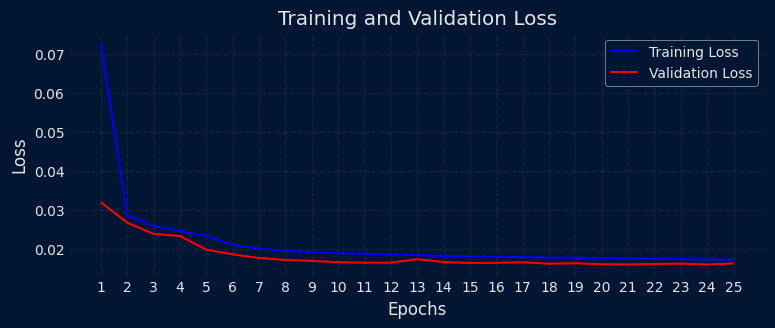

In [19]:
# Train and overfitting tracking
# ==============================================================================
fig, ax = plt.subplots(figsize=(8, 3))
_ = forecaster.plot_history(ax=ax)

In this case, the prediction quality is expected to be lower than in the previous example, as shown by the higher loss values across epochs. This is easily explained: the model now has to predict 24 values at each step instead of just 1. As a result, the validation loss is higher, since it reflects the combined error across all 24 predicted values, rather than the error for a single value.

In [20]:
# Prediction
# ==============================================================================
predictions = forecaster.predict()
predictions.head(4)

,level,pred
2021-04-01 00:00:00,o3,51.359100
2021-04-01 01:00:00,o3,47.126167
2021-04-01 02:00:00,o3,45.461315
2021-04-01 03:00:00,o3,42.005844


In [21]:
# Specific step predictions
# ==============================================================================
predictions = forecaster.predict(steps=[1, 3])
predictions

,level,pred
2021-04-01 00:00:00,o3,51.359100
2021-04-01 02:00:00,o3,45.461315


In [22]:
# Backtesting 
# ==============================================================================
cv = TimeSeriesFold(
         steps              = forecaster.max_step,
         initial_train_size = len(data.loc[:end_validation, :]),  # Training + Validation Data
         refit              = False
     )

# The validation partition is now used as part of the initial fit
# Epocs is set to the value idenfied in the previous training with early stopping
forecaster.set_fit_kwargs({"epochs": 25,"batch_size": 512})

metrics, predictions = backtesting_forecaster_multiseries(
    forecaster        = forecaster,
    series            = data[['o3']],
    cv                = cv,
    levels            = forecaster.levels,
    metric            = "mean_absolute_error",
    verbose           = False,
    suppress_warnings = True
)

Epoch 1/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0171 - val_loss: 0.0162
Epoch 2/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0170 - val_loss: 0.0157
Epoch 3/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0167 - val_loss: 0.0158
Epoch 4/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0168 - val_loss: 0.0160
Epoch 5/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0168 - val_loss: 0.0157
Epoch 6/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0167 - val_loss: 0.0157
Epoch 7/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0166 - val_loss: 0.0156
Epoch 8/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0168 - val_loss: 0.0159
Epoch 9/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0168 - val_loss: 0.0159
Epoch 10/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0167 - val_loss: 0.0156
Epoch 11/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0166 - val_loss: 0.0156
Epoch 12/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0166 - val_l

  0%|          | 0/92 [00:00<?, ?it/s]

In [23]:
# Backtesting metrics
# ==============================================================================
metric_single_series = metrics.loc[metrics["levels"] == "o3", "mean_absolute_error"].iat[0]
metrics

,levels,mean_absolute_error
0,o3,10.823983


In [24]:
# Backtesting predictions
# ==============================================================================
predictions

,level,fold,pred
2021-10-01 00:00:00,o3,0,54.407433
2021-10-01 01:00:00,o3,0,53.473778
2021-10-01 02:00:00,o3,0,51.890850
2021-10-01 03:00:00,o3,0,50.524418
2021-10-01 04:00:00,o3,0,47.873085
...,...,...,...
2021-12-31 19:00:00,o3,91,18.544615
2021-12-31 20:00:00,o3,91,16.607071
2021-12-31 21:00:00,o3,91,18.459581
2021-12-31 22:00:00,o3,91,23.496634


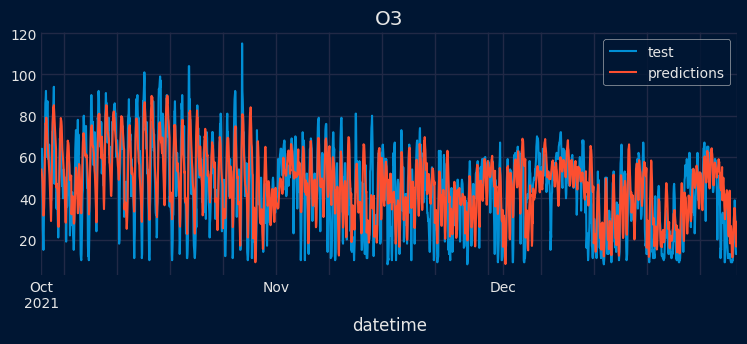

In [25]:
# Plotting predictions vs real values in the test set
# ==============================================================================
fig, ax = plt.subplots(figsize=(8, 3))
data_test["o3"].plot(ax=ax, label="test")
predictions.loc[predictions["level"] == "o3", "pred"].plot(ax=ax, label="predictions")
ax.set_title("O3")
ax.legend();

### 3. Multi-Series, Single-Output Forecasting (N:1, Multiple Steps)

In this scenario, the goal is to predict future values of a **single target** time series by leveraging the past values of **multiple related series as predictors**. This is known as **multivariate forecasting**, where the model uses the historical data from several variables to improve the prediction of one specific series.

For example: Suppose you want to forecast ozone concentration (`o3`) for the next 24 hours. In addition to past `o3` values, you may include other series—such as temperature, wind speed, or other pollutant concentrations—as predictors. The model will then use the combined information from all available series to make a more accurate forecast.

**Model setup**

To handle this type of problem, the **neural network architecture becomes a bit more complex**. An additional recurrent layer is used to process the information from multiple input series, and another dense (fully connected) layer further processes the output from the recurrent layer. With **skforecast**, building such a model is straightforward: simply pass a list of integers to the `recurrent_units` and `dense_units` arguments to add multiple recurrent and dense layers as needed.

In [26]:
# Create model
# ==============================================================================
lags = 24

model = create_and_compile_model(
    series                  = data,    # DataFrame with all series (predictors)
    levels                  = ["o3"],  # Target series to predict
    lags                    = lags,    # Number of lags to use as predictors
    steps                   = 24,      # Multi-step forecasting
    recurrent_layer         = "GRU",
    recurrent_units         = [128, 64],
    recurrent_layers_kwargs = {"activation": "tanh"},
    dense_units             = [64, 32],
    compile_kwargs          = {'optimizer': 'adam', 'loss': 'mse'},
    model_name              = "MultiVariate-Multi-Step" 
)

model.summary()

keras version: 3.10.0
Using backend: tensorflow
tensorflow version: 2.19.0



Model: "MultiVariate-Multi-Step"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ series_input (InputLayer)       │ (None, 24, 10)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 24, 128)        │        53,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_dense_td_layer (Dense)   │ (None, 24)             │           792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 24, 1)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 98,040 (382.97 KB)

 Trainable params: 98,040 (382.97 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
# Forecaster Creation
# ==============================================================================
forecaster = ForecasterRnn(
    estimator=model,
    levels=["o3"],
    lags=lags,
    transformer_series=MinMaxScaler(),
    fit_kwargs={
        "epochs": 25, 
        "batch_size": 512, 
        "callbacks": [
            EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
        ],  # Callback to stop training when it is no longer learning.
        "series_val": data_val,  # Validation data for model training.
    },
)

# Fit forecaster
# ==============================================================================
forecaster.fit(data_train)

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 26 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.1042 - val_loss: 0.0328
Epoch 2/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0293 - val_loss: 0.0257
Epoch 3/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0259 - val_loss: 0.0236
Epoch 4/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0239 - val_loss: 0.0207
Epoch 5/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0215 - val_loss: 0.0181
Epoch 6/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0198 - val_loss: 0.0179
Epoch 7/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0191 - val_loss: 0.0166
Epoch 8/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0183 - val_loss: 0.0163
Epoch 9/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0182 - val_loss: 0.0160
Epoch 10/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0177 - val_loss: 0.0159
Epoch 11/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0173 - val_loss: 0.0163
Epoch 12/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0

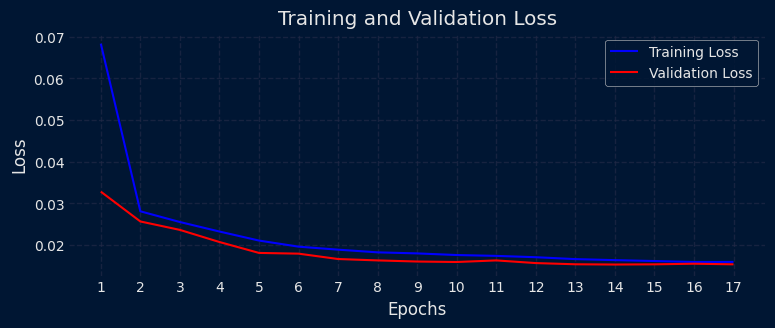

In [28]:
# Training and overfitting tracking
# ==============================================================================
fig, ax = plt.subplots(figsize=(8, 3))
_ = forecaster.plot_history(ax=ax)

In [29]:
# Prediction
# ==============================================================================
predictions = forecaster.predict()
predictions.head(4)

,level,pred
2021-04-01 00:00:00,o3,50.479244
2021-04-01 01:00:00,o3,44.066982
2021-04-01 02:00:00,o3,37.910641
2021-04-01 03:00:00,o3,35.630486


In [30]:
# Backtesting with test data
# ==============================================================================
cv = TimeSeriesFold(
         steps              = forecaster.max_step,
         initial_train_size = len(data.loc[:end_validation, :]),  # Training + Validation Data
         refit              = False
     )

# The validation partition is now used as part of the initial fit
# Epocs is set to the value idenfied in the previous training with early stopping
forecaster.set_fit_kwargs({"epochs": 21,"batch_size": 512})

metrics, predictions = backtesting_forecaster_multiseries(
    forecaster        = forecaster,
    series            = data,
    cv                = cv,
    levels            = forecaster.levels,
    metric            = "mean_absolute_error",
    suppress_warnings = True,
    verbose           = False
)

Epoch 1/21
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0161 - val_loss: 0.0149
Epoch 2/21
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0159 - val_loss: 0.0147
Epoch 3/21
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0156 - val_loss: 0.0145
Epoch 4/21
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0156 - val_loss: 0.0144
Epoch 5/21
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0154 - val_loss: 0.0143
Epoch 6/21
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0153 - val_loss: 0.0145
Epoch 7/21
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0151 - val_loss: 0.0142
Epoch 8/21
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0150 - val_loss: 0.0141
Epoch 9/21
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0150 - val_loss: 0.0142
Epoch 10/21
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0148 - val_loss: 0.0143
Epoch 11/21
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0149 - val_loss: 0.0139
Epoch 12/21
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0

  0%|          | 0/92 [00:00<?, ?it/s]

In [31]:
# Backtesting metrics
# ==============================================================================
metric_multivariate = metrics.loc[metrics["levels"] == "o3", "mean_absolute_error"].iat[0]
metrics

,levels,mean_absolute_error
0,o3,11.180846


In [32]:
# Backtesting predictions
# ==============================================================================
predictions

,level,fold,pred
2021-10-01 00:00:00,o3,0,52.147778
2021-10-01 01:00:00,o3,0,48.982948
2021-10-01 02:00:00,o3,0,43.842770
2021-10-01 03:00:00,o3,0,36.077209
2021-10-01 04:00:00,o3,0,33.824505
...,...,...,...
2021-12-31 19:00:00,o3,91,28.595161
2021-12-31 20:00:00,o3,91,24.911968
2021-12-31 21:00:00,o3,91,22.230385
2021-12-31 22:00:00,o3,91,23.645475


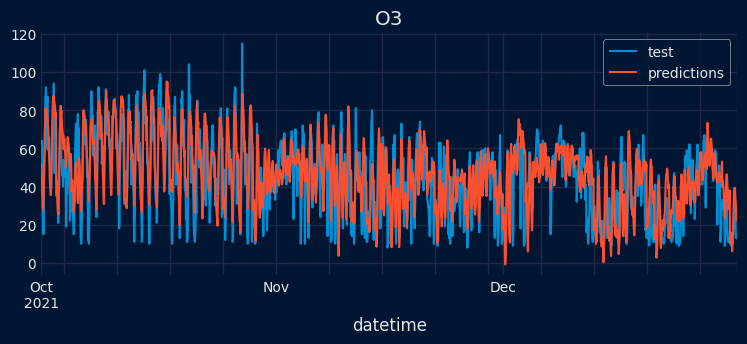

In [33]:
# Plotting predictions vs real values in the test set
# ==============================================================================
fig, ax = plt.subplots(figsize=(8, 3))
data_test["o3"].plot(ax=ax, label="test")
predictions.loc[predictions["level"] == "o3", "pred"].plot(ax=ax, label="predictions")
ax.set_title("O3")
ax.legend()
plt.show()

When using multiple time series as predictors, it is often expected that the model will produce more accurate forecasts for the target series. However, in this example, the predictions are actually worse than in the previous case where only a single series was used as input. This may happen if the additional time series used as predictors are not strongly related to the target series. As a result, the model is unable to learn meaningful relationships, and the extra information does not improve performance—in fact, it may even introduce noise.

### 4. Multi-Series, Multi-Output Forecasting (N:M, Multiple Steps)

In this scenario, the goal is to predict multiple future values for several time series at once, using the historical data from all available series as input. This is known as **multivariate-multioutput forecasting**.

With this approach, a **single model learns to predict several target series** simultaneously, capturing relationships and dependencies not only within each series, but also across different series.

Real-world applications include:

+ Forecasting the sales of multiple products in an online store, leveraging past sales, pricing history, promotions, and other product-related variables.

+ Study the flue gas emissions of a gas turbine, where you want to predict the concentration of multiple pollutants (e.g., NOX, CO) based on past emissions data and other related variables.

+ Modeling environmental variables (e.g., pollution, temperature, humidity) together, where the evolution of one variable may influence or be influenced by others.

In [34]:
# Create model
# ==============================================================================
levels = ['o3', 'pm2.5', 'pm10']  # Multiple target series to predict
lags = 24

model = create_and_compile_model(
    series                  = data,    # DataFrame with all series (predictors)
    levels                  = levels, 
    lags                    = lags, 
    steps                   = 24, 
    recurrent_layer         = "LSTM",
    recurrent_units         = [128, 64],
    recurrent_layers_kwargs = {"activation": "tanh"},
    dense_units             = [64, 32],
    compile_kwargs          = {'optimizer': Adam(), 'loss': MeanSquaredError()},
    model_name              = "MultiVariate-MultiOutput-Multi-Step"
)

model.summary()

keras version: 3.10.0
Using backend: tensorflow
tensorflow version: 2.19.0



Model: "MultiVariate-MultiOutput-Multi-Step"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ series_input (InputLayer)       │ (None, 24, 10)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 24, 128)        │        71,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_dense_td_layer (Dense)   │ (None, 72)             │         2,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 24, 3)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 129,192 (504.66 KB)

 Trainable params: 129,192 (504.66 KB)

 Non-trainable params: 0 (0.00 B)

In [35]:
# Forecaster Creation
# ==============================================================================
forecaster = ForecasterRnn(
    estimator=model,
    levels=levels,
    lags=lags,
    transformer_series=MinMaxScaler(),
    fit_kwargs={
        "epochs": 25, 
        "batch_size": 512, 
        "callbacks": [
            EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
        ],  # Callback to stop training when it is no longer learning.
        "series_val": data_val,  # Validation data for model training.
    },
)

# Fit forecaster
# ==============================================================================
forecaster.fit(data_train)

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 26 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0488 - val_loss: 0.0194
Epoch 2/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0158 - val_loss: 0.0103
Epoch 3/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0121 - val_loss: 0.0098
Epoch 4/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0114 - val_loss: 0.0093
Epoch 5/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0107 - val_loss: 0.0087
Epoch 6/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0098 - val_loss: 0.0074
Epoch 7/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0088 - val_loss: 0.0068
Epoch 8/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0083 - val_loss: 0.0064
Epoch 9/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0079 - val_loss: 0.0064
Epoch 10/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0079 - val_loss: 0.0063
Epoch 11/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0076 - val_loss: 0.0062
Epoch 12/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0

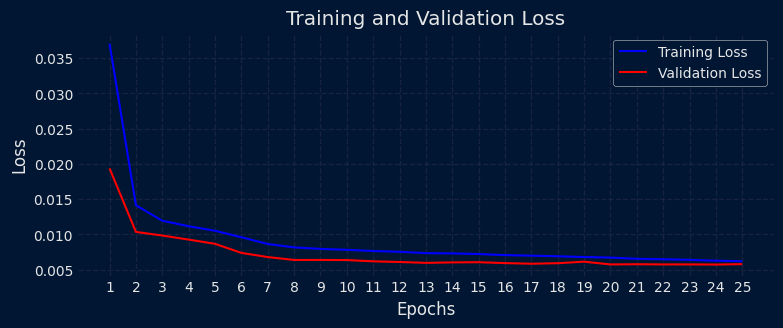

In [36]:
# Training and overfitting tracking
# ==============================================================================
fig, ax = plt.subplots(figsize=(8, 3))
_ = forecaster.plot_history(ax=ax)

Predictions can be made for specific `steps` and `levels` as long as they are within the prediction horizon defined by the model. For example, you can predict ozone concentration (`levels = "o3"`) for the next one and five hours (`steps = [1, 5]`).

In [37]:
# Specific steps and levels predictions
# ==============================================================================
forecaster.predict(steps=[1, 5], levels="o3")

,level,pred
2021-04-01 00:00:00,o3,53.599098
2021-04-01 04:00:00,o3,32.882313


In [38]:
# Predictions for all steps and levels
# ==============================================================================
predictions = forecaster.predict()
predictions

,level,pred
2021-04-01 00:00:00,o3,53.599098
2021-04-01 00:00:00,pm2.5,12.391732
2021-04-01 00:00:00,pm10,15.698824
2021-04-01 01:00:00,o3,49.828526
2021-04-01 01:00:00,pm2.5,14.887287
...,...,...
2021-04-01 22:00:00,pm2.5,11.487748
2021-04-01 22:00:00,pm10,10.726659
2021-04-01 23:00:00,o3,61.714333
2021-04-01 23:00:00,pm2.5,12.743458


In [39]:
# Backtesting with test data
# ==============================================================================
cv = TimeSeriesFold(
         steps              = forecaster.max_step,
         initial_train_size = len(data.loc[:end_validation, :]),  # Training + Validation Data
         refit              = False
     )

# The validation partition is now used as part of the initial fit
# Epocs is set to the value idenfied in the previous training with early stopping
forecaster.set_fit_kwargs({"epochs": 20,"batch_size": 512})

metrics, predictions = backtesting_forecaster_multiseries(
    forecaster        = forecaster,
    series            = data,
    cv                = cv,
    levels            = forecaster.levels,
    metric            = "mean_absolute_error",
    suppress_warnings = True,
    verbose           = False
)

Epoch 1/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0061 - val_loss: 0.0053
Epoch 2/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0060 - val_loss: 0.0053
Epoch 3/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0060 - val_loss: 0.0053
Epoch 4/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0058 - val_loss: 0.0052
Epoch 5/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0059 - val_loss: 0.0051
Epoch 6/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0057 - val_loss: 0.0051
Epoch 7/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0057 - val_loss: 0.0051
Epoch 8/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0056 - val_loss: 0.0050
Epoch 9/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0056 - val_loss: 0.0050
Epoch 10/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0055 - val_loss: 0.0050
Epoch 11/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0054 - val_loss: 0.0048
Epoch 12/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0

  0%|          | 0/92 [00:00<?, ?it/s]

In [40]:
# Backtesting metrics
# ==============================================================================
metric_multivariate_multioutput = metrics.loc[metrics["levels"] == "o3", "mean_absolute_error"].iat[0]
metrics

,levels,mean_absolute_error
0,o3,12.643964
1,pm2.5,4.122679
2,pm10,12.418521
3,average,9.728388
4,weighted_average,9.728388
5,pooling,9.728388


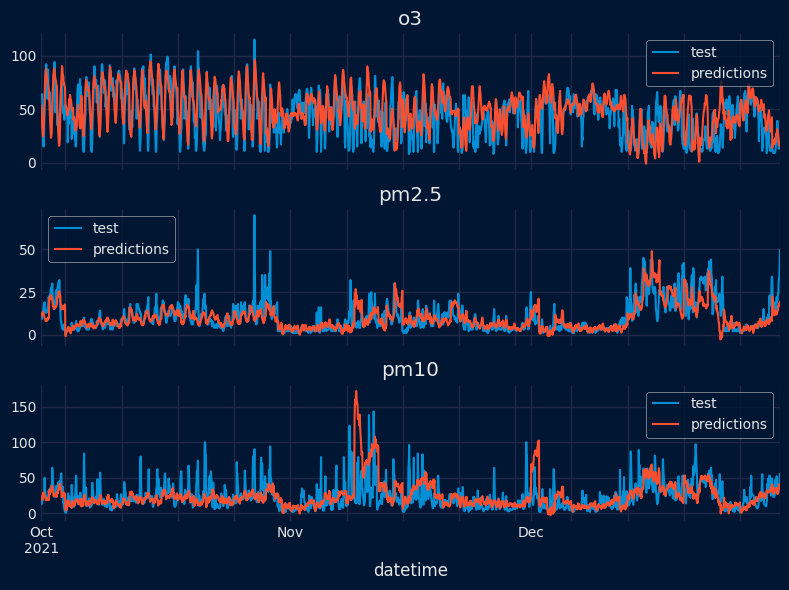

In [41]:
# Plot all the predicted variables as rows in the plot
# ==============================================================================
fig, ax = plt.subplots(len(levels), 1, figsize=(8, 2 * len(levels)), sharex=True)
for i, level in enumerate(levels):
    data_test[level].plot(ax=ax[i], label="test")
    predictions.loc[predictions["level"] == level, "pred"].plot(ax=ax[i], label="predictions")
    ax[i].set_title(level)
    ax[i].legend()

plt.tight_layout()
plt.show()

### Comparing Forecasting Strategies

As we have seen, various deep learning architectures and modeling strategies can be employed for time series forecasting. In summary, the forecasting approaches can be categorized into:

+ **Single series, multi-step forecasting:** Predict future values of a single series using only its past values.

+ **Multivariate, single-output, multi-step forecasting:** Use several series as predictors to forecast a target series over multiple future time steps.

+ **Multivariate, multi-output, multi-step forecasting:** Use multiple predictor series to forecast several targets over multiple steps.

Below is a summary table comparing the **Mean Absolute Error (MAE)** for each approach, calculated on the same target series, `"o3"`:

In [42]:
# Metric comparison
# ==============================================================================
results = {
    "Single-Series, Multi-Step": metric_single_series,
    "Multi-Series, Single-Output": metric_multivariate,
    "Multi-Series, Multi-Output": metric_multivariate_multioutput
}

table_results = pd.DataFrame.from_dict(results, orient='index', columns=['O3 MAE'])
table_results = table_results.style.highlight_min(axis=0, color='green').format(precision=4)
table_results

,O3 MAE
"Single-Series, Multi-Step",10.8240
"Multi-Series, Single-Output",11.1808
"Multi-Series, Multi-Output",12.6440


In this example, the **single-series** and **simple multivariate** approaches produce similar errors, while adding more targets as outputs (multi-output) increases the prediction error. However, **there is no universal rule**: the best strategy depends on your data, domain, and prediction goals.

It's important to **experiment** with different architectures and compare their metrics to select the most appropriate model for your specific use case.

## Exogenous variables in deep learning models

Exogenous variables are **external predictors** (such as weather, holidays, or special events) that can influence the target series but are not part of its own historical values. When building deep learning models for time series forecasting, including **these variables can help capture important patterns and improve accuracy**, as long as their future values are available at prediction time.

In this section, we’ll demonstrate how to use exogenous variables in deep learning models with a new dataset: `bike_sharing`, which contains hourly bike usage in Washington D.C., together with weather and holiday information.

To learn more about exogenous variables in **skforecast** visit the [exogenous variables user guide](../user_guides/exogenous-variables.html).

In [43]:
# Data download
# ==============================================================================
data_exog = fetch_dataset(name='bike_sharing', raw=False)
data_exog = data_exog[['users', 'temp', 'hum', 'windspeed', 'holiday']]
data_exog = data_exog.loc['2011-04-01 00:00:00':'2012-10-20 23:00:00', :].copy()
data_exog.head(3)

╭───────────────────────────────── bike_sharing ──────────────────────────────────╮
│ Description:                                                                    │
│ Hourly usage of the bike share system in the city of Washington D.C. during the │
│ years 2011 and 2012. In addition to the number of users per hour, information   │
│ about weather conditions and holidays is available.                             │
│                                                                                 │
│ Source:                                                                         │
│ Fanaee-T,Hadi. (2013). Bike Sharing Dataset. UCI Machine Learning Repository.   │
│ https://doi.org/10.24432/C5W894.                                                │
│                                                                                 │
│ URL:                                                                            │
│ https://raw.githubusercontent.com/skforecast/skforecast-                        │
│ datasets/main/data/bike_sharing_dataset_clean.csv                               │
│                                                                                 │
│ Shape: 17544 rows x 11 columns                                                  │
╰─────────────────────────────────────────────────────────────────────────────────╯

,users,temp,hum,windspeed,holiday
date_time,,,,,
2011-04-01 00:00:00,6.0,10.66,100.0,11.0014,0.0
2011-04-01 01:00:00,4.0,10.66,100.0,11.0014,0.0
2011-04-01 02:00:00,7.0,10.66,93.0,12.9980,0.0


In [44]:
# Calendar features
# ==============================================================================
features_to_extract = [
    'month',
    'week',
    'day_of_week',
    'hour'
]
calendar_transformer = DatetimeFeatures(
    variables           = 'index',
    features_to_extract = features_to_extract,
    drop_original       = False,
)

# Cyclical encoding of calendar features
# ==============================================================================
features_to_encode = [
    "month",
    "week",
    "day_of_week",
    "hour",
]
max_values = {
    "month": 12,
    "week": 52,
    "day_of_week": 7,
    "hour": 24,
}
cyclical_encoder = CyclicalFeatures(
                       variables     = features_to_encode,
                       max_values    = max_values,
                       drop_original = True
                   )

exog_transformer = make_pipeline(
                       calendar_transformer,
                       cyclical_encoder
                   )

data_exog = exog_transformer.fit_transform(data_exog)
exog_features = data_exog.columns.difference(['users']).tolist()

print(f"Exogenous features: {exog_features}")
data_exog.head(3)

Exogenous features: ['day_of_week_cos', 'day_of_week_sin', 'holiday', 'hour_cos', 'hour_sin', 'hum', 'month_cos', 'month_sin', 'temp', 'week_cos', 'week_sin', 'windspeed']


,users,temp,hum,windspeed,holiday,month_sin,month_cos,week_sin,week_cos,day_of_week_sin,day_of_week_cos,hour_sin,hour_cos
date_time,,,,,,,,,,,,,
2011-04-01 00:00:00,6.0,10.66,100.0,11.0014,0.0,0.866025,-0.5,1.0,6.123234e-17,-0.433884,-0.900969,0.000000,1.000000
2011-04-01 01:00:00,4.0,10.66,100.0,11.0014,0.0,0.866025,-0.5,1.0,6.123234e-17,-0.433884,-0.900969,0.258819,0.965926
2011-04-01 02:00:00,7.0,10.66,93.0,12.9980,0.0,0.866025,-0.5,1.0,6.123234e-17,-0.433884,-0.900969,0.500000,0.866025


In [45]:
# Split train-validation-test
# ==============================================================================
end_train = '2012-06-30 23:59:00'
end_validation = '2012-10-01 23:59:00'
data_exog_train = data_exog.loc[: end_train, :]
data_exog_val   = data_exog.loc[end_train:end_validation, :]
data_exog_test  = data_exog.loc[end_validation:, :]

print(f"Dates train      : {data_exog_train.index.min()} --- {data_exog_train.index.max()}  (n={len(data_exog_train)})")
print(f"Dates validation : {data_exog_val.index.min()} --- {data_exog_val.index.max()}  (n={len(data_exog_val)})")
print(f"Dates test       : {data_exog_test.index.min()} --- {data_exog_test.index.max()}  (n={len(data_exog_test)})")

Dates train      : 2011-04-01 00:00:00 --- 2012-06-30 23:00:00  (n=10968)
Dates validation : 2012-07-01 00:00:00 --- 2012-10-01 23:00:00  (n=2232)
Dates test       : 2012-10-02 00:00:00 --- 2012-10-20 23:00:00  (n=456)


The architecture of your deep learning model must be able to accept extra inputs alongside the main time series data. The `create_and_compile_model` function makes this straightforward: simply pass the exogenous variables as a DataFrame to the `exog` argument.

In [46]:
# `create_and_compile_model` with exogenous variables
# ==============================================================================
series = ['users']
levels = ['users']
lags = 72

model = create_and_compile_model(
    series                  = data_exog[series],         # Single-series
    levels                  = levels,                    # One target series to predict
    lags                    = lags, 
    steps                   = 36, 
    exog                    = data_exog[exog_features],  # Exogenous variables
    recurrent_layer         = "LSTM",
    recurrent_units         = [128, 64],
    recurrent_layers_kwargs = {"activation": "tanh"},
    dense_units             = [64, 32],
    compile_kwargs          = {'optimizer': Adam(learning_rate=0.01), 'loss': 'mse'},
    model_name              = "Single-Series-Multi-Step-Exog"
)

model.summary()

keras version: 3.10.0
Using backend: tensorflow
tensorflow version: 2.19.0



Model: "Single-Series-Multi-Step-Exog"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ series_input        │ (None, 72, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 72, 128)   │     66,560 │ series_input[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 64)        │     49,408 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 36, 64)    │          0 │ lstm_2[0][0]      │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ exog_input          │ (None, 36, 12)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat_exog         │ (None, 36, 76)    │          0 │ repeat_vector[0]… │
│ (Concatenate)       │                   │            │ exog_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_td_1          │ (None, 36, 64)    │      4,928 │ concat_exog[0][0] │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_td_2          │ (None, 36, 32)    │      2,080 │ dense_td_1[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_dense_td_la… │ (None, 36, 1)     │         33 │ dense_td_2[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 123,009 (480.50 KB)

 Trainable params: 123,009 (480.50 KB)

 Non-trainable params: 0 (0.00 B)

In [47]:
# Plotting the model architecture (require `pydot` and `graphviz`)
# ==============================================================================
# from keras.utils import plot_model
# plot_model(model, show_shapes=True, show_layer_names=True, to_file='model-architecture-exog.png')

<p style="text-align: center">
    <img src='../img/model-architecture-exog.png'style="width: 400px">
</p>

In [48]:
# Forecaster Creation
# ==============================================================================
forecaster = ForecasterRnn(
    estimator=model,
    levels=levels,
    lags=lags, 
    transformer_series=MinMaxScaler(),
    transformer_exog=MinMaxScaler(),
    fit_kwargs={
        "epochs": 25, 
        "batch_size": 512, 
        "callbacks": [
            EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
            ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-5, verbose=1)
        ],  # Callback to stop training when it is no longer learning and to reduce learning rate.
        "series_val": data_exog_val[series],      # Validation data for model training.
        "exog_val": data_exog_val[exog_features]  # Validation data for exogenous variables
    },
)

# Fit forecaster with exogenous variables
# ==============================================================================
forecaster.fit(
    series = data_exog_train[series], 
    exog   = data_exog_train[exog_features]
)

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 26 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - loss: 0.0508 - val_loss: 0.0459 - learning_rate: 0.0100
Epoch 2/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0152 - val_loss: 0.0303 - learning_rate: 0.0100
Epoch 3/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0119 - val_loss: 0.0287 - learning_rate: 0.0100
Epoch 4/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0096 - val_loss: 0.0216 - learning_rate: 0.0100
Epoch 5/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0078 - val_loss: 0.0156 - learning_rate: 0.0100
Epoch 6/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0086 - val_loss: 0.0200 - learning_rate: 0.0100
Epoch 7/25
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0066
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0065 - val_loss: 0.0213 - learning_rate: 0.0100
Epoch 8/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0053 - val_loss: 0.0140 - learning_rate: 0.005

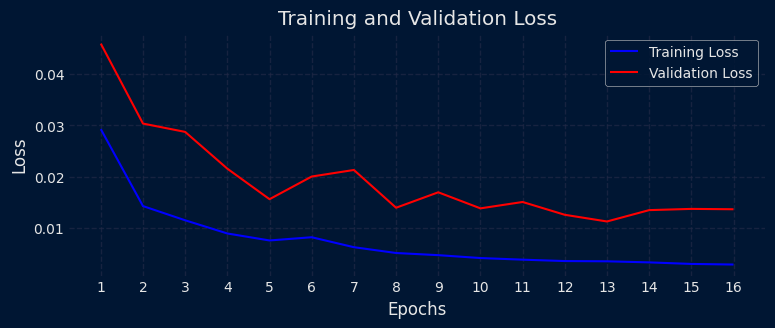

In [49]:
# Training and overfitting tracking
# ==============================================================================
fig, ax = plt.subplots(figsize=(8, 3))
_ = forecaster.plot_history(ax=ax)

The training history shows that while the training loss decreases smoothly, the validation loss stays higher and fluctuates across epochs. This suggests that the **model is likely overfitting**: it learns the training data well but struggles to generalize to new, unseen data. To address this, you could try adding regularization such as dropout, simplifying the model by reducing its size, or revisiting the choice of exogenous features to help improve validation performance.

When using exogenous variables, the predict requires additional information about the future values of these variables. This data must be provided through the `exog` argument in the `predict` method.

In [50]:
# Prediction with exogenous variables
# ==============================================================================
predictions = forecaster.predict(exog=data_exog_val[exog_features])
predictions.head(4)

,level,pred
2012-07-01 00:00:00,users,155.667374
2012-07-01 01:00:00,users,98.132439
2012-07-01 02:00:00,users,59.879463
2012-07-01 03:00:00,users,14.474176


In [51]:
# Backtesting with test data and exogenous variables
# ==============================================================================
cv = TimeSeriesFold(
         steps              = forecaster.max_step,
         initial_train_size = len(data_exog.loc[:end_validation, :]),  # Training + Validation Data
         refit              = False
     )

# The validation partition is now used as part of the initial fit
# Epocs is set to the value idenfied in the previous training with early stopping
forecaster.set_fit_kwargs({"epochs": 25,"batch_size": 512})

metrics, predictions = backtesting_forecaster_multiseries(
    forecaster        = forecaster,
    series            = data_exog[series],
    exog              = data_exog[exog_features],
    cv                = cv,
    levels            = forecaster.levels,
    metric            = "mean_absolute_error",
    suppress_warnings = True,
    verbose           = False
)

Epoch 1/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step - loss: 0.0044 - val_loss: 0.0067
Epoch 2/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0038 - val_loss: 0.0058
Epoch 3/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0035 - val_loss: 0.0056
Epoch 4/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0034 - val_loss: 0.0052
Epoch 5/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0033 - val_loss: 0.0048
Epoch 6/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0032 - val_loss: 0.0046
Epoch 7/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0030 - val_loss: 0.0046
Epoch 8/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0030 - val_loss: 0.0043
Epoch 9/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0029 - val_loss: 0.0041
Epoch 10/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0028 - val_loss: 0.0040
Epoch 11/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0027 - val_loss: 0.0040
Epoch 12/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.

  0%|          | 0/13 [00:00<?, ?it/s]

In [52]:
# Backtesting metrics
# ==============================================================================
metrics

,levels,mean_absolute_error
0,users,43.17297


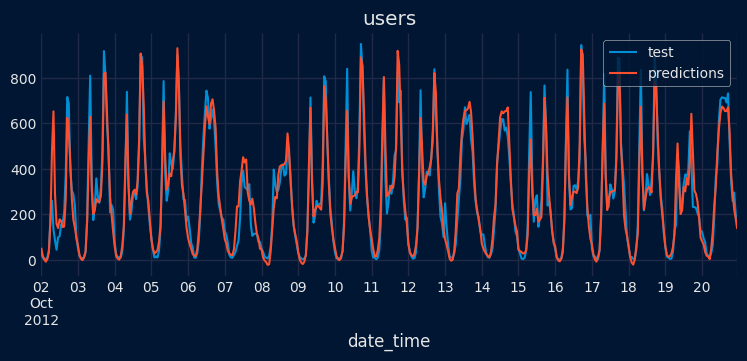

In [53]:
# Plotting predictions vs real values in the test set
# ==============================================================================
fig, ax = plt.subplots(figsize=(8, 3))
data_exog_test["users"].plot(ax=ax, label="test")
predictions.loc[predictions["level"] == "users", "pred"].plot(ax=ax, label="predictions")
ax.set_title("users")
ax.legend();

## Probabilistic forecasting with deep learning models

Conformal prediction is a framework for constructing prediction intervals that are guaranteed to contain the true value with a specified probability (coverage probability). It works by combining the predictions of a point-forecasting model with its past residuals, differences between previous predictions and actual values. These residuals help estimate the uncertainty in the forecast and determine the width of the prediction interval that is then added to the point forecast.

To learn more about conformal predictions in **skforecast**, visit the [Probabilistic Forecasting: Conformal Prediction](../user_guides/probabilistic-forecasting-conformal-prediction.html) user guide.

In [54]:
# Store in-sample residuals
# ==============================================================================
forecaster.set_in_sample_residuals(
    series=data_exog_train[series], exog=data_exog_train[exog_features]
)

In [55]:
# Prediction intervals
# ==============================================================================
predictions = forecaster.predict_interval(
    steps                   = None,
    exog                    = data_exog_val.loc[:, exog_features],
    interval                = [10, 90],  # 80% prediction interval
    method                  = 'conformal',
    use_in_sample_residuals = True
)

predictions.head(4)

,level,pred,lower_bound,upper_bound
2012-07-01 00:00:00,users,155.667364,91.004881,220.329846
2012-07-01 01:00:00,users,98.132441,33.469958,162.794923
2012-07-01 02:00:00,users,59.879460,-4.783022,124.541943
2012-07-01 03:00:00,users,14.474176,-50.188306,79.136659


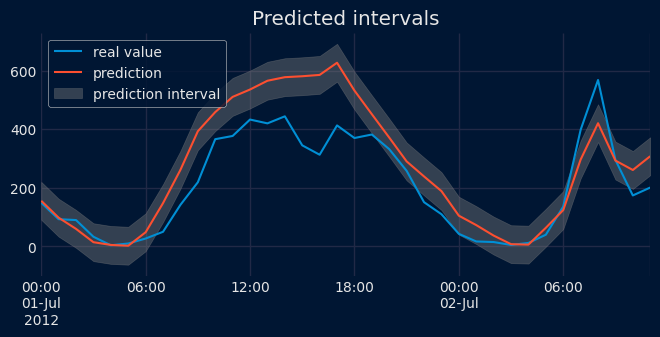

In [56]:
# Plot intervals
# ==============================================================================
plot_prediction_intervals(
    predictions         = predictions,
    y_true              = data_exog_val,
    target_variable     = "users",
    title               = "Predicted intervals",
    kwargs_fill_between = {'color': 'gray', 'alpha': 0.4, 'zorder': 1}
)

## Using Custom Loss Functions in Deep Learning Models

By default, Keras models in **skforecast** can be trained using common loss functions such as `MeanSquaredError` or `MeanAbsoluteError`. However, in many forecasting tasks it is useful to design a **custom loss function** that reflects the specific goals of your problem. For example, you may want to penalize underestimation more than overestimation, handle imbalanced data, or directly optimize for a business-specific metric.

Keras and **skforecast** make this process straightforward:

+ You can define a loss as a **Python function** that takes `y_true` and `y_pred` tensors and returns a scalar loss value.

+ For reproducibility and model saving/loading, custom losses should be registered with `@keras.saving.register_keras_serializable()`.

This flexibility enables you to customize the training process according to your forecasting domain, ensuring that the model optimizes the metrics that are most relevant to your use case.

In [ ]:
# Create custom loss function with tensorflow
# ==============================================================================
# import tensorflow as tf
# @keras.saving.register_keras_serializable(package="custom", name="weighted_mae")
# def weighted_mae(y_true, y_pred):
#     error = tf.abs(y_true - y_pred)
#     weights = tf.abs(y_true)
    
#     return tf.reduce_mean(error * weights)

# Create custom loss function with pytorch
# ==============================================================================
@keras.saving.register_keras_serializable(package="custom", name="weighted_mae")
def weighted_mae(y_true, y_pred):
    """
    Compute weighted mean absolute error.
    
    Args:
        y_true (torch.Tensor): Ground truth values.
        y_pred (torch.Tensor): Predicted values.
    
    Returns:
        torch.Tensor: Weighted MAE loss (scalar).
    """
    error = torch.abs(y_true - y_pred)
    weights = torch.abs(y_true)
    return torch.mean(error * weights)

In [58]:
# `create_and_compile_model` with custom loss function
# ==============================================================================
series = ['users']
levels = ['users']
lags = 72

model = create_and_compile_model(
    series                  = data_exog[series],
    levels                  = levels, 
    lags                    = lags, 
    steps                   = 36, 
    exog                    = data_exog[exog_features], 
    recurrent_layer         = "LSTM",
    recurrent_units         = [128, 64],
    recurrent_layers_kwargs = {"activation": "tanh"},
    dense_units             = [64, 32],
    compile_kwargs          = {'optimizer': Adam(learning_rate=0.01), 'loss': weighted_mae},  # Custom loss function
    model_name              = "Single-Series-Multi-Step-Exog"
)

model.summary()

keras version: 3.10.0
Using backend: tensorflow
tensorflow version: 2.19.0



Model: "Single-Series-Multi-Step-Exog"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ series_input        │ (None, 72, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 72, 128)   │     66,560 │ series_input[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 64)        │     49,408 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 36, 64)    │          0 │ lstm_2[0][0]      │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ exog_input          │ (None, 36, 12)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat_exog         │ (None, 36, 76)    │          0 │ repeat_vector[0]… │
│ (Concatenate)       │                   │            │ exog_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_td_1          │ (None, 36, 64)    │      4,928 │ concat_exog[0][0] │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_td_2          │ (None, 36, 32)    │      2,080 │ dense_td_1[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_dense_td_la… │ (None, 36, 1)     │         33 │ dense_td_2[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 123,009 (480.50 KB)

 Trainable params: 123,009 (480.50 KB)

 Non-trainable params: 0 (0.00 B)

In [59]:
# Forecaster Creation
# ==============================================================================
forecaster = ForecasterRnn(
    estimator=model,
    levels=levels,
    lags=lags, 
    transformer_series=MinMaxScaler(),
    transformer_exog=MinMaxScaler(),
    fit_kwargs={
        "epochs": 25, 
        "batch_size": 1024, 
        "callbacks": [
            EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
            ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-5, verbose=1)
        ],  # Callback to stop training when it is no longer learning and to reduce learning rate.
        "series_val": data_exog_val[series],      # Validation data for model training.
        "exog_val": data_exog_val[exog_features]  # Validation data for exogenous variables
    },
)

# Fit forecaster with exogenous variables
# ==============================================================================
forecaster.fit(
    series = data_exog_train[series], 
    exog   = data_exog_train[exog_features]
)

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 26 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 192ms/step - loss: 0.0834 - val_loss: 0.0598 - learning_rate: 0.0100
Epoch 2/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0295 - val_loss: 0.0630 - learning_rate: 0.0100
Epoch 3/25
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0266
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0265 - val_loss: 0.0634 - learning_rate: 0.0100
Epoch 4/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0250 - val_loss: 0.0641 - learning_rate: 0.0050


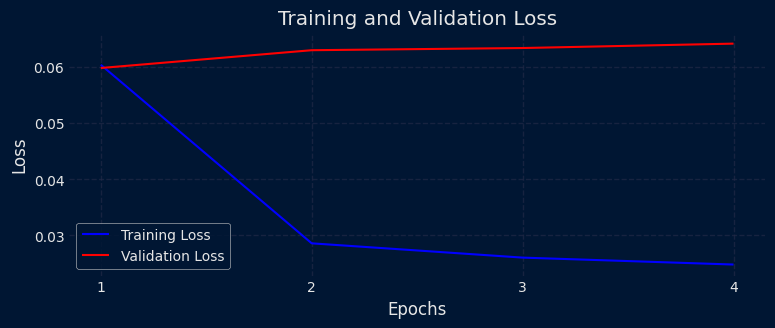

In [60]:
# Training and overfitting tracking
# ==============================================================================
fig, ax = plt.subplots(figsize=(8, 3))
_ = forecaster.plot_history(ax=ax)

In [61]:
# Prediction with exogenous variables
# ==============================================================================
predictions = forecaster.predict(exog=data_exog_val[exog_features])
predictions.head(4)

,level,pred
2012-07-01 00:00:00,users,414.701172
2012-07-01 01:00:00,users,407.501556
2012-07-01 02:00:00,users,399.923981
2012-07-01 03:00:00,users,391.778442


## Understanding create_and_compile_model in depth

The `create_and_compile_model` function is designed to streamline the **process of building and compiling RNN-based Keras models for time series forecasting**, with or without exogenous variables. This function allows both rapid prototyping (with sensible defaults) and fine-grained customization for advanced users.

**How the function works**

At its core, `create_and_compile_model` builds a neural network that consists of three main building blocks:

+ **Recurrent Layers (LSTM, GRU, or SimpleRNN):** These layers capture temporal dependencies in the data. You can control the type, number, and configuration of recurrent layers using `recurrent_layer`, recurrent_units, and `recurrent_layers_kwargs`.

+ **Dense (Fully Connected) Layers:** After temporal features are extracted, dense layers help model nonlinear relationships between learned features and the forecasting target(s). The structure is controlled by `dense_units` and `dense_layers_kwargs`.

+ **Output Layer:** The final dense layer matches the number of forecasting targets (`levels`) and steps (`steps`). Its configuration can be adjusted with `output_dense_layer_kwargs`.

If you include exogenous variables (`exog`), the function automatically adjusts the input structure so that the model receives both the main time series and additional features.

**Parameters**

+ `series`: Main time series data (as a DataFrame), each column is treated as an input feature.

+ `lags`: Number of past time steps to use as predictors. Defines the input sequence length. The same value must be used later in the **ForecasterRnn** `lags` argument.

+ `steps`: Number of future time steps to predict.

+ `levels`: List of variables to predict (target variables). Can be one or many columns from `series`. If `None`, defaults to the names of input series.

+ `exog`: Exogenous variables (optional), given as a DataFrame. Must be aligned with `series`.

+ `recurrent_layer`: Type of recurrent layer, choose between `'LSTM'`, `'GRU'`, or `'RNN'`. **Keras API:** [LSTM](https://keras.io/api/layers/recurrent_layers/lstm/), [GRU](https://keras.io/api/layers/recurrent_layers/gru/), [SimpleRNN](https://keras.io/api/layers/recurrent_layers/simple_rnn/).

+ `recurrent_units`: Number of units per recurrent layer. Accepts a single int (for one layer) or a list/tuple for multiple stacked layers.

+ `recurrent_layers_kwargs`: Dictionary (same for all layers) or lists of dictionaries (one per layer) with keyword arguments for the respective recurrent layers (e.g., activation functions, dropout, etc.).

+ `dense_units`: Number of units per dense layer. Accepts a single int (for one layer) or a list/tuple for multiple stacked layers.

+ `dense_layers_kwargs`: Dictionary (same for all layers) or lists of dictionaries (one per layer) with keyword arguments for the respective dense layers (e.g., activation functions, dropout, etc.).

+ `output_dense_layer_kwargs`: Dictionary with keyword arguments for the output dense layer (e.g., activation function, dropout, etc.). Defaults to `{'activation': 'linear'}`.

+ `compile_kwargs`: Dictionary of parameters for Keras’s `compile()` method, e.g. optimizer, loss function. Defaults to `{'optimizer': Adam(), 'loss': MeanSquaredError()}`.

+ `model_name`: Name of the model.

Visit the [full API documentation](../api/forecasterrnn.html#skforecast.deep_learning.utils.create_and_compile_model) for `create_and_compile_model` for more details.

### Example: Model summary and layer-by-layer explanation (no exog)

In [62]:
# Model summary `create_and_compile_model`
# ==============================================================================
model = create_and_compile_model(
            series          = data, 
            levels          = ["o3"], 
            lags            = 32, 
            steps           = 24, 
            recurrent_layer = "GRU", 
            recurrent_units = 100,
            dense_units     = 64 
        )

model.summary()

keras version: 3.10.0
Using backend: tensorflow
tensorflow version: 2.19.0



Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ series_input (InputLayer)       │ (None, 32, 10)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 100)            │        33,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         6,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_dense_td_layer (Dense)   │ (None, 24)             │         1,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 24, 1)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,624 (162.59 KB)

 Trainable params: 41,624 (162.59 KB)

 Non-trainable params: 0 (0.00 B)

| Layer Name              | Type         | Output Shape     | Param #  | Description                                                                   |
|-------------------------|--------------|------------------|----------|------------------------------------------------------------------------------|
| series_input            | `InputLayer` | `(None, 32, 10)` | 0        | Input layer of the model. It receives input sequences of length 32 (lags) with 10 features (predictors series) per step.                                |
| gru_1                   | `GRU`        | `(None, 100)`    | 33,600   | GRU (Gated Recurrent Unit) layer with 100 units and 'tanh' activation. Learns patterns and dependencies over time in the input data.                        |
| dense_1                 | `Dense`      | `(None, 64)`     | 6,464    | Fully connected (dense) layer with 64 units and ReLU activation. Processes the features extracted by the GRU layer.                                      |
| output_dense_td_layer   | `Dense`      | `(None, 24)`     | 1,560    | Dense output layer with 24 units (one for each of the 24 future time steps to predict), linear activation.                                                  |
| reshape                 | `Reshape`    | `(None, 24, 1)`  | 0        | Reshapes the output to match the format (**steps**, **output variables**). Here, `steps=24` and `levels=["o3"]`, so the final output is `(None, 24, 1)`. |

**Total params:** 41,624 &nbsp;&nbsp; **Trainable params:** 41,624 &nbsp;&nbsp; **Non-trainable params:** 0

### Example: Model summary and layer-by-layer explanation (exog)

In [63]:
# Create calendar exogenous variables
# ==============================================================================
data['hour'] = data.index.hour
data['day_of_week'] = data.index.dayofweek
data = pd.get_dummies(
    data, columns=['hour', 'day_of_week'], drop_first=True, dtype=float
)
data.head(3)

,so2,co,no,no2,pm10,nox,o3,veloc.,direc.,pm2.5,...,hour_20,hour_21,hour_22,hour_23,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
datetime,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,8.0,0.2,3.0,36.0,22.0,40.0,16.0,0.5,262.0,19.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2019-01-01 01:00:00,8.0,0.1,2.0,40.0,32.0,44.0,6.0,0.6,248.0,26.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2019-01-01 02:00:00,8.0,0.1,11.0,42.0,36.0,58.0,3.0,0.3,224.0,31.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [64]:
# Model summary `create_and_compile_model` with exogenous variables
# ==============================================================================
series = ['so2', 'co', 'no', 'no2', 'pm10', 'nox', 'o3', 'veloc.', 'direc.', 'pm2.5']
exog_features = data.columns.difference(series).tolist()  # dayofweek_* and hour_*
levels = ['o3', 'pm2.5', 'pm10']  # Multiple target series to predict

print("Target series:", levels)
print("Series as predictors:", series)
print("Exogenous variables:", exog_features)
print("")

model = create_and_compile_model(
    series                    = data[series],
    levels                    = levels, 
    lags                      = 32,
    steps                     = 24,
    exog                      = data[exog_features],  
    recurrent_layer           = "LSTM",    
    recurrent_units           = [128, 64],  
    recurrent_layers_kwargs   = [{'activation': 'tanh'}, {'activation': 'relu'}],
    dense_units               = [128, 64],
    dense_layers_kwargs       = {'activation': 'relu'},
    output_dense_layer_kwargs = {'activation': 'linear'},
    compile_kwargs            = {'optimizer': Adam(), 'loss': MeanSquaredError()},
    model_name                = None
)

model.summary()

Target series: ['o3', 'pm2.5', 'pm10']
Series as predictors: ['so2', 'co', 'no', 'no2', 'pm10', 'nox', 'o3', 'veloc.', 'direc.', 'pm2.5']
Exogenous variables: ['day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'hour_1', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_2', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9']

keras version: 3.10.0
Using backend: tensorflow
tensorflow version: 2.19.0



Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ series_input        │ (None, 32, 10)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 32, 128)   │     71,168 │ series_input[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 64)        │     49,408 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 24, 64)    │          0 │ lstm_2[0][0]      │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ exog_input          │ (None, 24, 29)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat_exog         │ (None, 24, 93)    │          0 │ repeat_vector[0]… │
│ (Concatenate)       │                   │            │ exog_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_td_1          │ (None, 24, 128)   │     12,032 │ concat_exog[0][0] │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_td_2          │ (None, 24, 64)    │      8,256 │ dense_td_1[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_dense_td_la… │ (None, 24, 3)     │        195 │ dense_td_2[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 141,059 (551.01 KB)

 Trainable params: 141,059 (551.01 KB)

 Non-trainable params: 0 (0.00 B)

| Layer Name              | Type                        | Output Shape      | Param #  | Description                                                                                                                        |
|-------------------------|-----------------------------|-------------------|----------|------------------------------------------------------------------------------------------------------------------------------------|
| series_input            | `InputLayer`                | `(None, 32, 10)`  | 0        | Input layer for the main time series. Receives sequences of 32 time steps (`lags`) for 10 features (predictor series).             |
| lstm_1                  | `LSTM`                      | `(None, 32, 128)` | 71,168   | First LSTM layer with 128 units, `'tanh'` activation. Learns temporal patterns and dependencies from the input sequences.           |
| lstm_2                  | `LSTM`                      | `(None, 64)`      | 49,408   | Second LSTM layer with 64 units, `'relu'` activation. Further summarizes the temporal information.                                  |
| repeat_vector           | `RepeatVector`              | `(None, 24, 64)`  | 0        | Repeats the output of the previous LSTM layer 24 times, one for each future time step to predict.                                  |
| exog_input              | `InputLayer`                | `(None, 24, 29)`  | 0        | Input layer for the 29 exogenous variables (calendar and hour features) for each of the 24 future time steps.                      |
| concat_exog             | `Concatenate`               | `(None, 24, 93)`  | 0        | Concatenates the repeated LSTM output and the exogenous variables for each prediction time step, joining all features together.     |
| dense_td_1              | `TimeDistributed (Dense)`   | `(None, 24, 128)` | 12,032   | Dense layer (128 units, ReLU) applied independently to each of the 24 time steps, learning complex relationships from all features. |
| dense_td_2              | `TimeDistributed (Dense)`   | `(None, 24, 64)`  | 8,256    | Second dense layer (64 units, ReLU), also applied to each time step, further processes the combined features.                      |
| output_dense_td_layer   | `TimeDistributed (Dense)`   | `(None, 24, 3)`   | 195      | Final output layer, predicts 3 target variables (`levels`) for each of the 24 future steps (`'linear'` activation).                |


**Total params:** 141,059  **Trainable params:** 141,059  **Non-trainable params:** 0


## Running on GPU

**skforecast** is fully compatible with **GPU acceleration**. If your computer has a compatible GPU and the right software installed, **skforecast** will automatically use the GPU to speed up training.

**Tips for GPU Training**

+ **Batch size matters:** Large batch sizes (for example, 64, 128, 256, or even more) allow the GPU to process more data in one go, making training much faster compared to a CPU. Small batch sizes (for example, 8 or 16) don’t use all the power of the GPU, so training may be only a little faster—or sometimes not faster at all—than using just the CPU.

+ **Performance boost:** On a suitable GPU, training can be many times faster than on CPU. For example, with a large batch size, an **NVIDIA T4 GPU** can reduce training time from over a minute (CPU) to just a few seconds (GPU).

**How to use the GPU with skforecast**

1. Install the **GPU version of PyTorch** (with CUDA support). Visit the [PyTorch installation page](https://pytorch.org/get-started/locally/) and follow the instructions for your system. Make sure to select the version that matches your GPU and CUDA version. For example, to install PyTorch with CUDA 12.6, you can run:

```bash
pip install torch --index-url https://download.pytorch.org/whl/cu126
```

2. Check if your **GPU** is available in Python:

In [65]:
# Check if GPU is available
# ==============================================================================
import torch

print("Torch version  :", torch.__version__)
print("Cuda available :", torch.cuda.is_available())
print("Device name    :", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")

Torch version  : 2.9.0+cu126
Cuda available : True
Device name    : Tesla T4


3. Run your code as usual. If a GPU is detected, **skforecast** will use it automatically.

## How to Extract training and test matrices

While forecasting models are mainly used to predict future values, it's just as important to understand **how the model is learning from the training data**. Analyzing **input and output matrices** used during training, **predictions on the training data** or exploring the **prediction matrices** is crucial for assessing model performance and understanding areas for optimization. This process can reveal whether the model is overfitting, underfitting, or struggling with specific patterns in the data.

<div class="admonition note" name="html-admonition" style="background: rgba(255,145,0,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #ff9100; border-color: #ff9100; padding-left: 10px; padding-right: 10px">

<p class="title">
    <i style="font-size: 18px; color:#ff9100; border-color: #ff1744;"></i>
    <b style="color: #ff9100;"> <span style="color: #ff9100;">&#9888;</span> Warning</b>
</p>

If any <a href="../user_guides/sklearn-transformers-and-pipeline.html">data transformations</a> is applied, it will affect the output matrices. Consequently, the predictions generated in this transformed scale may require additional steps to revert back to the original data scale.

</div>

In [66]:
# Split train-test
# ==============================================================================
end_train = "2021-09-30 23:59:00"
data_train = data.loc[:end_train, :].copy()
data_test = data.loc[end_train:, :].copy()

print(
    f"Dates train : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})"
)
print(
    f"Dates test  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})"
)

data_train.head(3)

Dates train : 2019-01-01 00:00:00 --- 2021-09-30 23:00:00  (n=24096)
Dates test  : 2021-10-01 00:00:00 --- 2021-12-31 23:00:00  (n=2208)


,so2,co,no,no2,pm10,nox,o3,veloc.,direc.,pm2.5,...,hour_20,hour_21,hour_22,hour_23,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
datetime,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,8.0,0.2,3.0,36.0,22.0,40.0,16.0,0.5,262.0,19.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2019-01-01 01:00:00,8.0,0.1,2.0,40.0,32.0,44.0,6.0,0.6,248.0,26.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2019-01-01 02:00:00,8.0,0.1,11.0,42.0,36.0,58.0,3.0,0.3,224.0,31.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [67]:
# Model summary `create_and_compile_model` with exogenous variables
# ==============================================================================
lags = 5
series = ['so2', 'co', 'no', 'no2', 'pm10', 'nox', 'o3', 'veloc.', 'direc.', 'pm2.5']
exog_features = data_train.columns.difference(series).tolist()  # dayofweek_* and hour_*
levels = ['o3', 'pm2.5', 'pm10']  # Multiple target series to predict

print("Target series:", levels)
print("Series as predictors:", series)
print("Exogenous variables:", exog_features)
print("")

model = create_and_compile_model(
            series          = data_train[series],
            levels          = levels, 
            lags            = lags,
            steps           = 4,
            exog            = data_train[exog_features],  
            recurrent_layer = "GRU",    
            recurrent_units = 64,
            dense_units     = 32
        )

model.summary()

Target series: ['o3', 'pm2.5', 'pm10']
Series as predictors: ['so2', 'co', 'no', 'no2', 'pm10', 'nox', 'o3', 'veloc.', 'direc.', 'pm2.5']
Exogenous variables: ['day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'hour_1', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_2', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9']

keras version: 3.10.0
Using backend: tensorflow
tensorflow version: 2.19.0



Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ series_input        │ (None, 5, 10)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_1 (GRU)         │ (None, 64)        │     14,592 │ series_input[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 4, 64)     │          0 │ gru_1[0][0]       │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ exog_input          │ (None, 4, 29)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat_exog         │ (None, 4, 93)     │          0 │ repeat_vector[0]… │
│ (Concatenate)       │                   │            │ exog_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_td_1          │ (None, 4, 32)     │      3,008 │ concat_exog[0][0] │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_dense_td_la… │ (None, 4, 3)      │         99 │ dense_td_1[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 17,699 (69.14 KB)

 Trainable params: 17,699 (69.14 KB)

 Non-trainable params: 0 (0.00 B)

In [68]:
# Forecaster creation
# ==============================================================================
forecaster = ForecasterRnn(
                 estimator          = model, 
                 levels             = levels, 
                 lags               = lags, 
                 transformer_series = MinMaxScaler(), 
                 transformer_exog   = MinMaxScaler(),
             )

forecaster.fit(series=data_train[series], exog=data_train[exog_features])
forecaster

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 16 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


753/753 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0187


============= 
ForecasterRnn 
============= 
Estimator: <Functional name=functional_4, built=True> 
Layers names: ['series_input', 'gru_1', 'repeat_vector', 'exog_input', 'concat_exog', 'dense_td_1', 'output_dense_td_layer'] 
Lags: [1 2 3 4 5] 
Window size: 5 
Maximum steps to predict: [1 2 3 4] 
Series names: so2, co, no, no2, pm10, nox, o3, veloc., direc., pm2.5 
Target series (levels): ['o3', 'pm2.5', 'pm10'] 
Exogenous included: True 
Exogenous names: 
    day_of_week_1, day_of_week_2, day_of_week_3, day_of_week_4, day_of_week_5,
    day_of_week_6, hour_1, hour_10, hour_11, hour_12, hour_13, hour_14, hour_15,
    hour_16, hour_17, hour_18, hour_19, hour_2, hour_20, hour_21, hour_22,
    hour_23, hour_3, hour_4, hour_5, hour_6, hour_7, hour_8, hour_9 
Transformer for series: MinMaxScaler() 
Transformer for exog: MinMaxScaler() 
Training range: [Timestamp('2019-01-01 00:00:00'), Timestamp('2021-09-30 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: <Hour> 
Estimator parameters: {'name': 'functional_4', 'trainable': True, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': (None, 5, 10), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'series_input'}, 'registered_name': None, 'name': 'series_input', 'inbound_nodes': []}, {'module': 'keras.layers', 'class_name': 'GRU', 'config': {'name': 'gru_1', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'return_sequences': False, 'return_state': False, 'go_backwards': False, 'stateful': False, 'unroll': False, 'zero_output_for_mask': False, 'units': 64, 'activation': 'tanh', 'recurrent_activation': 'sigmoid', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'recurrent_initializer': {'module': 'keras.initializers', 'class_name': 'Orthogonal', 'config': {'seed': None, 'gain': 1.0}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'recurrent_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'recurrent_constraint': None, 'bias_constraint': None, 'dropout': 0.0, 'recurrent_dropout': 0.0, 'reset_after': True, 'seed': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 10]}, 'name': 'gru_1', 'inbound_nodes': [{'args': ({'class_name': '__keras_tensor__', 'config': {'shape': (None, 5, 10), 'dtype': 'float32', 'keras_history': ['series_input', 0, 0]}},), 'kwargs': {'training': False, 'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'RepeatVector', 'config': {'name': 'repeat_vector', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'n': 4}, 'registered_name': None, 'build_config': {'input_shape': [None, 64]}, 'name': 'repeat_vector', 'inbound_nodes': [{'args': ({'class_name': '__keras_tensor__', 'config': {'shape': (None, 64), 'dtype': 'float32', 'keras_history': ['gru_1', 0, 0]}},), 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': (None, 4, 29), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'exog_input'}, 'registered_name': None, 'name': 'exog_input', 'inbound_nodes': []}, {'module': 'keras.layers', 'class_name': 'Concatenate', 'config': {'name': 'concat_exog', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'axis': -1}, 'registered_name': None, 'build_config': {'input_shape': [[None, 4, 64], [None, 4, 29]]}, 'name': 'concat_exog', 'inbound_nodes': [{'args': ([{'class_name': '__keras_tensor__', 'config': {'shape': (None, 4, 64), 'dtype': 'float32', 'keras_history': ['repeat_vector', 0, 0]}}, {'c

The `ForecasterRNN` provides the method `create_train_X_y`, which allows you to directly extract the matrices used for training. This can be very helpful for debugging, feature engineering, or advanced analysis. This method returns four elements:

+ **X_train:** Training values (predictors) for each step. The resulting array has 3 dimensions: (`n_observations`, `n_lags`, `n_series`)

+ **exog_train:** Value of exogenous variables (if any) aligned with `X_train`. (`n_observations`, `n_steps`, `n_exog`)

+ **y_train:** Values (target) of the time series related to each row of `X_train`. The resulting array has 3 dimensions: (`n_observations`, `n_steps`, `n_levels`)

+ **dimension_names:** A dictionary with the labels (names) for each axis in the arrays, helping you interpret which dimension corresponds to lags, features, steps, etc.

In [69]:
# Extract training info
# ==============================================================================
X_train, exog_train, y_train, dimension_names = forecaster.create_train_X_y(
    series=data_train[series], exog=data_train[exog_features]
)

In [70]:
# Check the shape of the training data
# ==============================================================================
print(f"X_train shape        : {X_train.shape} --- (train index, lags, predictors)")
print(f"exog_train shape     : {exog_train.shape} --- (train index, steps, exogenous variables)")
print(f"y_train shape        : {y_train.shape}  --- (train index, steps, levels)")
print(f"dimension_names keys : {list(dimension_names.keys())}")

X_train shape        : (24088, 5, 10) --- (train index, lags, predictors)
exog_train shape     : (24088, 4, 29) --- (train index, steps, exogenous variables)
y_train shape        : (24088, 4, 3)  --- (train index, steps, levels)
dimension_names keys : ['X_train', 'y_train', 'exog_train']


In [71]:
# X_train dimension names
# ==============================================================================
dimension_names['X_train']  # (train index, lags, predictors)

{0: DatetimeIndex(['2019-01-01 05:00:00', '2019-01-01 06:00:00',
                '2019-01-01 07:00:00', '2019-01-01 08:00:00',
                '2019-01-01 09:00:00', '2019-01-01 10:00:00',
                '2019-01-01 11:00:00', '2019-01-01 12:00:00',
                '2019-01-01 13:00:00', '2019-01-01 14:00:00',
                ...
                '2021-09-30 11:00:00', '2021-09-30 12:00:00',
                '2021-09-30 13:00:00', '2021-09-30 14:00:00',
                '2021-09-30 15:00:00', '2021-09-30 16:00:00',
                '2021-09-30 17:00:00', '2021-09-30 18:00:00',
                '2021-09-30 19:00:00', '2021-09-30 20:00:00'],
               dtype='datetime64[ns]', name='datetime', length=24088, freq='h'),
 1: ['lag_5', 'lag_4', 'lag_3', 'lag_2', 'lag_1'],
 2: ['so2',
  'co',
  'no',
  'no2',
  'pm10',
  'nox',
  'o3',
  'veloc.',
  'direc.',
  'pm2.5']}

In [72]:
# exog_train dimension names
# ==============================================================================
dimension_names['exog_train']  # (train index, steps, exogenous variables)

{0: DatetimeIndex(['2019-01-01 05:00:00', '2019-01-01 06:00:00',
                '2019-01-01 07:00:00', '2019-01-01 08:00:00',
                '2019-01-01 09:00:00', '2019-01-01 10:00:00',
                '2019-01-01 11:00:00', '2019-01-01 12:00:00',
                '2019-01-01 13:00:00', '2019-01-01 14:00:00',
                ...
                '2021-09-30 11:00:00', '2021-09-30 12:00:00',
                '2021-09-30 13:00:00', '2021-09-30 14:00:00',
                '2021-09-30 15:00:00', '2021-09-30 16:00:00',
                '2021-09-30 17:00:00', '2021-09-30 18:00:00',
                '2021-09-30 19:00:00', '2021-09-30 20:00:00'],
               dtype='datetime64[ns]', name='datetime', length=24088, freq='h'),
 1: ['step_1', 'step_2', 'step_3', 'step_4'],
 2: ['day_of_week_1',
  'day_of_week_2',
  'day_of_week_3',
  'day_of_week_4',
  'day_of_week_5',
  'day_of_week_6',
  'hour_1',
  'hour_10',
  'hour_11',
  'hour_12',
  'hour_13',
  'hour_14',
  'hour_15',
  'hour_16',
  'hour_1

In [73]:
# y_train dimension names
# ==============================================================================
dimension_names['y_train']  # (train index, steps, levels)

{0: DatetimeIndex(['2019-01-01 05:00:00', '2019-01-01 06:00:00',
                '2019-01-01 07:00:00', '2019-01-01 08:00:00',
                '2019-01-01 09:00:00', '2019-01-01 10:00:00',
                '2019-01-01 11:00:00', '2019-01-01 12:00:00',
                '2019-01-01 13:00:00', '2019-01-01 14:00:00',
                ...
                '2021-09-30 11:00:00', '2021-09-30 12:00:00',
                '2021-09-30 13:00:00', '2021-09-30 14:00:00',
                '2021-09-30 15:00:00', '2021-09-30 16:00:00',
                '2021-09-30 17:00:00', '2021-09-30 18:00:00',
                '2021-09-30 19:00:00', '2021-09-30 20:00:00'],
               dtype='datetime64[ns]', name='datetime', length=24088, freq='h'),
 1: ['step_1', 'step_2', 'step_3', 'step_4'],
 2: ['o3', 'pm2.5', 'pm10']}

We can obtain the training predictions using the `predict` method of the estimator stored inside the forecaster object. By examining the predictions on the training data, analysts can get a better understanding of how the model is performing and make adjustments as necessary.

In [74]:
# Training predictions using the internal estimator
# ==============================================================================
forecaster.estimator.predict(
    x=X_train if exog_train is None else [X_train, exog_train], verbose=0
)[:3]

array([[[ 0.02613751,  0.24589527,  0.11588641],
        [-0.02565352,  0.25180757,  0.11244427],
        [-0.02532505,  0.24731562,  0.11150192],
        [ 0.02604451,  0.24925497,  0.12872788]],

       [[-0.02515816,  0.22548679,  0.09684443],
        [-0.02952632,  0.21994334,  0.09789944],
        [ 0.02653988,  0.22293416,  0.11312804],
        [ 0.09851486,  0.20284101,  0.10220706]],

       [[-0.0046935 ,  0.16102019,  0.07489269],
        [ 0.05314408,  0.16213223,  0.08654302],
        [ 0.12494736,  0.14240533,  0.07689081],
        [ 0.21563505,  0.13006043,  0.06752214]]], dtype=float32)

**Skforecast** provides the `create_predict_X` method to generate the matrices that the forecaster is using to make predictions. This method can be used to gain insight into the specific data manipulations that occur during the prediction process.

In [75]:
# Create input matrix for predict method
# ==============================================================================
X_predict, exog_predict = forecaster.create_predict_X(
    steps=None, exog=data_test[exog_features]
)
X_predict  # (None, lags, predictors)

╭───────────────────────────── DataTransformationWarning ──────────────────────────────╮
│ The output matrix is in the transformed scale due to the inclusion of                │
│ transformations in the Forecaster. As a result, any predictions generated using this │
│ matrix will also be in the transformed scale. Please refer to the documentation for  │
│ more details:                                                                        │
│ https://skforecast.org/latest/user_guides/training-and-prediction-matrices.html      │
│                                                                                      │
│ Category : skforecast.exceptions.DataTransformationWarning                           │
│ Location :                                                                           │
│ /usr/local/lib/python3.12/dist-packages/skforecast/deep_learning/_forecaster_rnn.py: │
│ 1369                                                                                 │
│ Suppress : warnings.simplefilter('ignore', category=DataTransformationWarning)       │
╰──────────────────────────────────────────────────────────────────────────────────────╯

,so2,co,no,no2,pm10,nox,o3,veloc.,direc.,pm2.5
lag_5,0.000000,0.000000,0.003086,0.054054,0.037383,0.015517,0.551471,0.062500,0.169444,0.074074
lag_4,0.055556,0.000000,0.003086,0.054054,0.040498,0.015517,0.536765,0.046875,0.130556,0.083333
lag_3,0.055556,0.006494,0.003086,0.060811,0.040498,0.018966,0.441176,0.046875,0.102778,0.074074
lag_2,0.111111,0.012987,0.003086,0.074324,0.031153,0.022414,0.419118,0.015625,0.105556,0.064815
lag_1,0.111111,0.019481,0.003086,0.074324,0.040498,0.022414,0.389706,0.015625,0.047222,0.083333


In [76]:
# Input matrix for predict method exogenous variables
# ==============================================================================
exog_predict  # (None, steps, exogenous variables)

,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,hour_1,hour_10,hour_11,hour_12,...,hour_21,hour_22,hour_23,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9
step_1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
step_2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
step_3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
step_4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
